## Centrality Depencence of Eloss and $p_T$ broadening for Charmonia & Bottomonia

### Import & setup

In [1]:
# ================================
# eLoss + broadening notebook (pub styling)
# ================================
import sys, os, math
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import replace
import torch
from matplotlib.lines import Line2D

sys.path.append("../eloss_code")

# --- imports & knobs ---
from particle  import Particle, PPSpectrumParams
from glauber   import SystemSpec, OpticalGlauber
from coupling  import alpha_s_provider
import quenching_fast as QF

# global floors
F1_FLOOR = 1e-16
F2_FLOOR = 1e-12   # for kinematic edge protection
ZC_EPS   = 1e-12

# energies, σ_nn, system
roots5, roots8   = 5023.0, 8160.0
sigma_nn_5, sigma_nn_8 = 67.6, 71.0
A = 208
device = "cuda" if (QF._HAS_TORCH and torch.cuda.is_available()) else "cpu"

# particles
P_charmonia  = Particle(family="charmonia",  state="avg")
P_bottomonia = Particle(family="bottomonia", state="avg")

# y and pT grids for raw curves
y_grid  = np.linspace(-5.0, 5.0, 256)
pT_grid = np.linspace(0.0, 20.0, 256)

# α_s (constant AP choice)
alpha_cst = alpha_s_provider(mode="constant", alpha0=0.5)
alpha_s   = alpha_cst

# Glauber for L_eff
gl5 = OpticalGlauber(SystemSpec("pA", roots5, A=A, sigma_nn_mb=sigma_nn_5))
gl8 = OpticalGlauber(SystemSpec("pA", roots8, A=A, sigma_nn_mb=sigma_nn_8))
Lmb_5 = gl5.leff_minbias_pA()
Lmb_8 = gl8.leff_minbias_pA()

# centrality bins → labels and colors
cent_bins = [(0,20),(20,40),(40,60),(60,80),(80,100)]
cent_labels = [f"{a}-{b}%" for (a,b) in cent_bins]
tags_order = ["0-20%", "20-40%", "40-60%", "60-80%", "80-100%"]
colors = {
    "0-20%":  "C0",
    "20-40%": "C1",
    "40-60%": "C2",
    "60-80%": "C3",
    "80-100%":"C4",
}

Leff_5 = gl5.leff_bins_pA(cent_bins, method="optical")
Leff_8 = gl8.leff_bins_pA(cent_bins, method="optical")

print("Leff mb:", Lmb_5, " , ", Lmb_8)
print("Leff 5 TeV pPb: ", Leff_5)
print("Leff 8 TeV pPb: ", Leff_8)

# base quench params (central qhat0)
QP5_base = QF.QuenchParams(
    qhat0        = 0.075,
    lp_fm        = 1.5,
    LA_fm        = Lmb_5,
    LB_fm        = Lmb_5,
    lambdaQCD    = 0.25,
    roots_GeV    = roots5,
    alpha_of_mu  = alpha_cst,
    alpha_scale  = "mT",
    use_hard_cronin = True,
    mapping      = "exp",
    device       = device,
)
QP8_base = replace(QP5_base,
                   roots_GeV = roots8,
                   LA_fm     = Lmb_8,
                   LB_fm     = Lmb_8)

## Three rapidity window to compute R_pA vs pT and R_pA vs Centrality
RAPIDITY_WINDOWS   = [(-4.46,-2.96), (-1.37,0.43), (2.03,3.53)]

# qhat0 band (center 0.075) -- to get error band in eloss
Q0_PAIR = (0.05, 0.09) 
# Other parameter for pp

def _qp_device(qp):
    """
    Use qp.device when possible. If qp.device=='cuda' but CUDA isn't available,
    fall back to CPU.
    """
    dev_str = getattr(qp, "device", None)
    if dev_str is None:
        dev_str = "cuda" if (QF._HAS_TORCH and torch.cuda.is_available()) else "cpu"
    if dev_str == "cuda" and not torch.cuda.is_available():
        dev_str = "cpu"
    return torch.device(dev_str)


## Make “scaled p0” particles (for broadening band)
from copy import deepcopy

def particle_with_scaled_p0(P: Particle, scale: float) -> Particle:
    """
    Return a new Particle with pp.p0 → scale * p0 (m,n unchanged).
    All other attributes (family, state, mass) are copied.
    """
    pp = P.pp
    new_pp = PPSpectrumParams(p0=pp.p0 * scale, m=pp.m, n=pp.n)
    return Particle(
        family=P.family,
        state=P.state,
        mass_override_GeV=P.mass_override_GeV,
        pp_params=new_pp,
    )

[Glauber] TA(r) LUT: A=208 d=0.549 r≤50 fm, dr=0.02, z≤50 fm
[Glauber] ∫T_A d^2x ≈ 208.483 (target A=208)
[Glauber] Tabulating T_AA(b), T_pA(b)…
[Glauber] σ_tot^AA ≈ 7724.42 mb, σ_tot^pA ≈ 1911.63 mb
[Glauber] TA(r) LUT: A=208 d=0.549 r≤50 fm, dr=0.02, z≤50 fm
[Glauber] ∫T_A d^2x ≈ 208.483 (target A=208)
[Glauber] Tabulating T_AA(b), T_pA(b)…
[Glauber] σ_tot^AA ≈ 7757.76 mb, σ_tot^pA ≈ 1925.90 mb
Leff mb: 10.414158247314315  ,  10.414158247314315
Leff 5 TeV pPb:  {'0-20%': 13.30462493265472, '20-40%': 10.811136886553728, '40-60%': 7.747887489470812, '60-80%': 4.705710625891892, '80-100%': 2.4437625515260213}
Leff 8 TeV pPb:  {'0-20%': 13.304624932654724, '20-40%': 10.775229950676886, '40-60%': 7.652683082523533, '60-80%': 4.64752469601636, '80-100%': 2.4437634046948857}


## Calculation of $R^{eloss}_{pA}$ and $R^{p_T \, broad}_{pA}$ [RAW]

#### pp Parameterization

In [2]:
# ---------- pp parametrisation: F1(pT) * F2(y,pT) ----------

def F1_t(P: Particle, pT_t: torch.Tensor) -> torch.Tensor:
    """
    F1(p_T) = (p0^2 / (p0^2 + p_T^2))^m
    """
    p0, m, _ = P.pp.p0, P.pp.m, P.pp.n
    p0_sq = float(p0) * float(p0)
    return (p0_sq / (p0_sq + pT_t * pT_t))**m

def F2_t(P: Particle,
         y_t: torch.Tensor,
         pT_t: torch.Tensor,
         roots_GeV: float) -> torch.Tensor:
    """
    F2(y,p_T) = [1 - 2 M_T cosh(y) / sqrt(s)]^n, clamped ≥ 0.
    """
    _, _, n = P.pp.p0, P.pp.m, P.pp.n
    M = float(P.M_GeV)
    roots = float(roots_GeV)
    pT_sq = pT_t * pT_t
    mT    = torch.sqrt(pT_sq + M*M)
    arg   = 1.0 - (2.0*mT/roots)*torch.cosh(y_t)
    arg_clamped = torch.clamp(arg, min=1e-30)
    return arg_clamped**n

def F2_t_pt(P: Particle,
            y_val: float,
            pT_t: torch.Tensor,
            roots_GeV: float,
            device=None) -> torch.Tensor:
    if device is None:
        device = pT_t.device
    y_t = torch.full_like(pT_t, float(y_val), device=device)
    return F2_t(P, y_t, pT_t, roots_GeV)

# ---------- x_A with safety clamp ----------

XMIN_SAFE = 1e-5
XMAX_SAFE = 0.99

def xA_scalar(P: Particle, roots_GeV: float, qp, y: float, pT: float) -> float:
    """
    x_A = min( x0(L_A), x_2 ) with
      x_2 = (m_T / sqrt(s)) e^{-y},
      x0(L_A) = ħc / (2 m_p L_A).
    Then clamped to [XMIN_SAFE, XMAX_SAFE].
    """
    M  = float(P.M_GeV)
    mT = math.sqrt(M*M + float(pT)**2)
    x2 = (mT / float(roots_GeV)) * math.exp(-float(y))
    x0 = QF.xA0_from_L(qp.LA_fm)
    xA = min(x0, x2)
    xA = max(XMIN_SAFE, min(XMAX_SAFE, xA))
    return float(xA)

#### $R^{eloss}_{pA}$, $R^{p_T \, broad}_{pA}$ & $R^{p_T \, eloss \times broad}_{pA}$ calculation

In [3]:
# ---------- Coherent energy-loss factor R_pA^loss ----------

def R_pA_eloss(
    P: Particle,
    roots_GeV: float,
    qp,
    y: float,
    pT: float,
    Ny: int | None = None,
) -> float:
    r"""
    Coherent energy-loss factor

      R_pA^loss(y,p_T;L_eff)
      = p0 + ∫ dδy  P̂_A(δy; x_A,L)
                   · [F2(y+δy,p_T) / F2(y,p_T)].

    where p0 = 1 - ∫ dδy P̂_A(δy) is the discrete
    no-loss probability (Arleo–Peigné).
    """
    if not QF._HAS_TORCH:
        raise RuntimeError("R_pA_eloss: torch (double precision) required.")

    device = _qp_device(qp)
    M   = float(P.M_GeV)
    pT0 = float(pT)
    mT  = math.sqrt(M*M + pT0*pT0)

    # kinematic δy_max
    y_max_pt = QF.y_max(roots_GeV, mT)
    dym      = QF.dymax(+y, y_max_pt)
    if dym <= QF.DY_EPS:
        return 1.0

    if Ny is None:
        Ny = QF._Ny_from_dymax(dym)

    xA_val = xA_scalar(P, roots_GeV, qp, y, pT0)

    with torch.no_grad():
        xA    = torch.tensor([xA_val], dtype=torch.float64, device=device)
        y0_t  = torch.tensor([y],     dtype=torch.float64, device=device)
        pT0_t = torch.tensor([pT0],   dtype=torch.float64, device=device)

        F2_den_t = F2_t(P, y0_t, pT0_t, roots_GeV)[0]
        if F2_den_t <= F2_FLOOR:
            return 1.0

        mapping = getattr(qp, "mapping", "exp")

        if mapping == "exp":
            # u = ln δy ∈ [umin, umax], δy = e^u
            umin = -30.0
            umax = math.log(max(dym, 1e-300))
            u, wu = QF._gl_nodes_torch(umin, umax, Ny, device)

            dy = torch.exp(u)
            z  = torch.expm1(dy).clamp_min(QF.Z_FLOOR)

            ph = QF.PhatA_t(z, mT, xA.expand_as(z), qp, pT=pT0)
            if (ph <= 0).all():
                return 1.0

            yshift = y + dy
            F2_num = F2_t(P, yshift, pT0_t.expand_as(yshift), roots_GeV)
            ratio  = F2_num / F2_den_t

            jac  = torch.exp(u)                # dδy/du
            val  = torch.sum(wu * jac * ph * ratio)
            Zc   = torch.sum(wu * jac * ph)

        else:
            # "linear" mapping: direct δy GL
            dy, wy = QF._gl_nodes_torch(0.0, float(dym), Ny, device)
            z  = torch.expm1(dy).clamp_min(QF.Z_FLOOR)

            ph = QF.PhatA_t(z, mT, xA.expand_as(z), qp, pT=pT0)
            if (ph <= 0).all():
                return 1.0

            yshift = y + dy
            F2_num = F2_t(P, yshift, pT0_t.expand_as(yshift), roots_GeV)
            ratio  = F2_num / F2_den_t

            val = torch.sum(wy * ph * ratio)
            Zc  = torch.sum(wy * ph)

        Zc = torch.clamp(Zc, min=0.0, max=1.0)
        if float(Zc.item()) < ZC_EPS:
            return 1.0

        p0 = torch.clamp(1.0 - Zc, 0.0, 1.0)   # discrete no-loss prob.
        R_loss = p0 + val
        return float(R_loss.item())


# ---------- pT broadening factor R_pA^broad ----------

def R_pA_broad(
    P: Particle,
    roots_GeV: float,
    qp,
    y: float,
    pT: float,
    Nphi: int = 256,
) -> float:
    r"""
    R_pA^broad(y,p_T;L_eff) =
      ∫_0^{2π} dφ/(2π) [F1(|p_T - δp_T(φ)|)/F1(p_T)]
                         · [F2(y,|p_T - δp_T(φ)|)/F2(y,p_T)].
    """
    if not QF._HAS_TORCH:
        raise RuntimeError("R_pA_broad: torch missing.")
    device = _qp_device(qp)

    with torch.no_grad():
        xA_val = xA_scalar(P, roots_GeV, qp, y, pT)
        xA = torch.tensor([xA_val], dtype=torch.float64, device=device)

        dpta = QF._dpt_from_xL_t(qp, xA, qp.LA_fm,
                                 hard=qp.use_hard_cronin)[0]
        if torch.abs(dpta) < 1e-8:
            return 1.0

        dpta = torch.clamp(dpta, min=-5.0, max=5.0)

        phi, wphi, cphi, sphi = QF._phi_nodes_gl_torch(Nphi, device)
        pshift = QF._shift_pT_pA(pT, dpta, cphi, sphi)

        pT0_t = torch.tensor([pT], dtype=torch.float64, device=device)

        # F1 ratio
        F1_den = F1_t(P, pT0_t)[0]
        if F1_den <= F1_FLOOR:
            return 1.0
        F1_num = F1_t(P, pshift)
        R1 = F1_num / F1_den

        # F2 ratio
        F2_den = F2_t_pt(P, y_val=y, pT_t=pT0_t,
                         roots_GeV=roots_GeV, device=device)[0]
        if F2_den <= F2_FLOOR:
            return 1.0
        F2_num = F2_t_pt(P, y_val=y, pT_t=pshift,
                         roots_GeV=roots_GeV, device=device)
        R2 = F2_num / F2_den

        R_phi   = R1 * R2
        R_broad = torch.sum(R_phi * wphi)
        return float(R_broad.item())


def R_pA_factored(
    P: Particle,
    roots_GeV: float,
    qp,
    y: float,
    pT: float,
    Ny_eloss: int | None = None,
    Nphi_broad: int = 64,
) -> float:
    """
    Factorised Arleo–Peigné approximation:
      R_pA ≃ R_pA^loss · R_pA^broad
    """
    Rloss  = R_pA_eloss(P, roots_GeV, qp, y, pT, Ny=Ny_eloss)
    Rbroad = R_pA_broad(P, roots_GeV, qp, y, pT, Nphi=Nphi_broad)
    return Rloss * Rbroad

#### $R^{eloss}_{pA}$, $R^{p_T \, broad}_{pA}$ & $R^{p_T \, eloss \times broad}_{pA}$ PLOTTING at Fixed Points

In [4]:
# -------------------------------------------------
# Raw curves R(y) and R(pT) per centrality
# -------------------------------------------------
def curves_vs_y(
    P, roots_GeV, qp_base, Leff_dict,
    y_grid, pT,
    Ny_eloss=256, Nphi_broad=256
):
    """
    For a given particle, energy, base qp, and dict of L_eff[tag]:
      result[tag] = (R_loss[y], R_broad[y], R_tot[y])
    """
    out = {}
    for tag, L in Leff_dict.items():
        qp_tag = replace(qp_base, LA_fm=float(L))
        Rl, Rb, Rt = [], [], []
        for y in y_grid:
            rl = R_pA_eloss(P, roots_GeV, qp_tag, y, pT, Ny=Ny_eloss)
            rb = R_pA_broad(P, roots_GeV, qp_tag, y, pT, Nphi=Nphi_broad)
            rt = rl * rb
            Rl.append(rl); Rb.append(rb); Rt.append(rt)
        out[tag] = (np.array(Rl), np.array(Rb), np.array(Rt))
    return out

def curves_vs_pT(
    P, roots_GeV, qp_base, Leff_dict,
    pT_grid, y_fix,
    Ny_eloss=128, Nphi_broad=256
):
    """
      result[tag] = (R_loss[pT], R_broad[pT], R_tot[pT])
    """
    out = {}
    for tag, L in Leff_dict.items():
        qp_tag = replace(qp_base, LA_fm=float(L))
        Rl, Rb, Rt = [], [], []
        for pT in pT_grid:
            rl = R_pA_eloss(P, roots_GeV, qp_tag, y_fix, pT, Ny=Ny_eloss)
            rb = R_pA_broad(P, roots_GeV, qp_tag, y_fix, pT, Nphi=Nphi_broad)
            rt = rl * rb
            Rl.append(rl); Rb.append(rb); Rt.append(rt)
        out[tag] = (np.array(Rl), np.array(Rb), np.array(Rt))
    return out

In [5]:
def make_RpA_vs_y_2row(
    P_charm, P_bottom,
    roots5, roots8, QP5_base, QP8_base,
    Leff_5, Leff_8,
    y_grid, pT_fix,
    tags_order, colors,
    include_5=True, include_8=True,
    Ny_eloss=128, Nphi_broad=128,
):
    if not include_5 and not include_8:
        raise ValueError("Need at least one energy.")

    res_ch_5 = res_bo_5 = res_ch_8 = res_bo_8 = None
    if include_5:
        res_ch_5 = curves_vs_y(P_charm,  roots5, QP5_base, Leff_5,
                               y_grid, pT_fix, Ny_eloss, Nphi_broad)
        res_bo_5 = curves_vs_y(P_bottom, roots5, QP5_base, Leff_5,
                               y_grid, pT_fix, Ny_eloss, Nphi_broad)
    if include_8:
        res_ch_8 = curves_vs_y(P_charm,  roots8, QP8_base, Leff_8,
                               y_grid, pT_fix, Ny_eloss, Nphi_broad)
        res_bo_8 = curves_vs_y(P_bottom, roots8, QP8_base, Leff_8,
                               y_grid, pT_fix, Ny_eloss, Nphi_broad)

    fig, axes = plt.subplots(2, 3, figsize=(7.0, 5.2),
                             dpi=130, sharex=True, sharey="row")
    ax_ch_loss, ax_ch_broad, ax_ch_tot = axes[0]
    ax_bo_loss, ax_bo_broad, ax_bo_tot = axes[1]

    def _plot_row(ax_loss, ax_broad, ax_tot, res5, res8, title):
        for tag in tags_order:
            col = colors[tag]
            if include_5 and res5 is not None:
                Rl5, Rb5, Rt5 = res5[tag]
                ax_loss.plot(y_grid, Rl5, color=col, ls="-")
                ax_broad.plot(y_grid, Rb5, color=col, ls="-")
                ax_tot.plot(y_grid, Rt5, color=col, ls="-")
            if include_8 and res8 is not None:
                Rl8, Rb8, Rt8 = res8[tag]
                ax_loss.plot(y_grid, Rl8, color=col, ls="--")
                ax_broad.plot(y_grid, Rb8, color=col, ls="--")
                ax_tot.plot(y_grid, Rt8, color=col, ls="--")

        ax_loss.set_ylabel(r"$R^{\rm loss}_{pA}$")
        ax_broad.set_ylabel(r"$R^{\rm broad}_{pA}$")
        ax_tot.set_ylabel(r"$R_{pA}$")
        ax_loss.text(0.02, 0.95, title, transform=ax_loss.transAxes,
                     ha="left", va="top", fontsize=9)

    _plot_row(ax_ch_loss, ax_ch_broad, ax_ch_tot,
              res_ch_5, res_ch_8, "Charmonia")
    _plot_row(ax_bo_loss, ax_bo_broad, ax_bo_tot,
              res_bo_5, res_bo_8, "Bottomonia")

    for ax in axes[1]:
        ax.set_xlabel(r"$y$")
    for row in axes:
        for ax in row:
            ax.grid(False)

    # centrality legend
    cent_handles = [Line2D([0],[0], color=colors[tag], lw=2, ls="-", label=tag)
                    for tag in tags_order]
    ax0 = ax_ch_loss
    leg1 = ax0.legend(handles=cent_handles, title="Centrality",
                      frameon=False, fontsize=7, loc="upper right")
    ax0.add_artist(leg1)

    # energy legend
    energy_handles = []
    if include_5:
        energy_handles.append(Line2D([0],[0], color="k", lw=2, ls="-",
            label=r"$\sqrt{s_{NN}} = 5.02$ TeV"))
    if include_8:
        energy_handles.append(Line2D([0],[0], color="k", lw=2, ls="--",
            label=r"$\sqrt{s_{NN}} = 8.16$ TeV"))
    if energy_handles:
        ax0.legend(handles=energy_handles, title="Energy",
                   frameon=False, fontsize=7, loc="lower left")

    fig.suptitle(rf"$p_T = {pT_fix:.1f}$ GeV", y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    return fig, axes

In [6]:
# # example: charmonia/bottomonia, 5 TeV only, pT = 2.5 GeV
# pT_fix = 1.5
# fig, axes = make_RpA_vs_y_2row(
#     P_charmonia, P_bottomonia,
#     roots5, roots8, QP5_base, QP8_base,
#     Leff_5, Leff_8,
#     y_grid, pT_fix,
#     tags_order, colors,
#     include_5=True, include_8=False,
# )

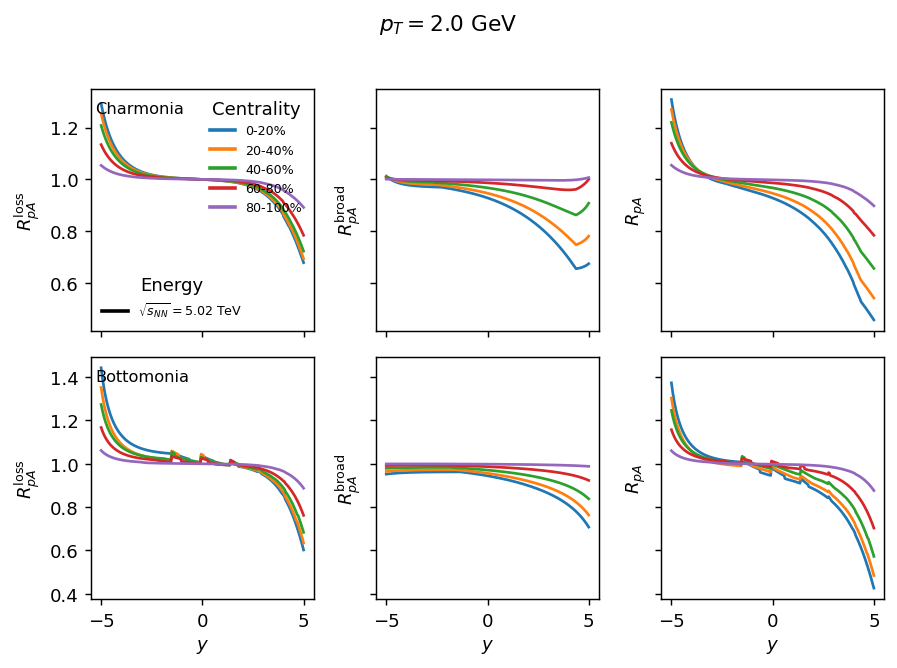

In [7]:
# fig, axes = make_RpA_vs_y_2row(
#     P_charmonia, P_bottomonia,
#     roots5, roots8, QP5_base, QP8_base,
#     Leff_5, Leff_8,
#     y_grid, pT_fix,
#     tags_order, colors
# )
# charmonia/bottomonia, 5 TeV only, pT = 2.5 GeV
pT_fix = 2.0
fig, axes = make_RpA_vs_y_2row(
    P_charmonia, P_bottomonia,
    roots5, roots8, QP5_base, QP8_base,
    Leff_5, Leff_8,
    y_grid, pT_fix,
    tags_order, colors,
    include_5=True, include_8=False,
)

In [8]:
# fig, axes = make_RpA_vs_y_2row(
#     P_charmonia, P_bottomonia,
#     roots5, roots8, QP5_base, QP8_base,
#     Leff_5, Leff_8,
#     y_grid, pT_fix,
#     tags_order, colors,
#     include_5=False, include_8=True,
# )

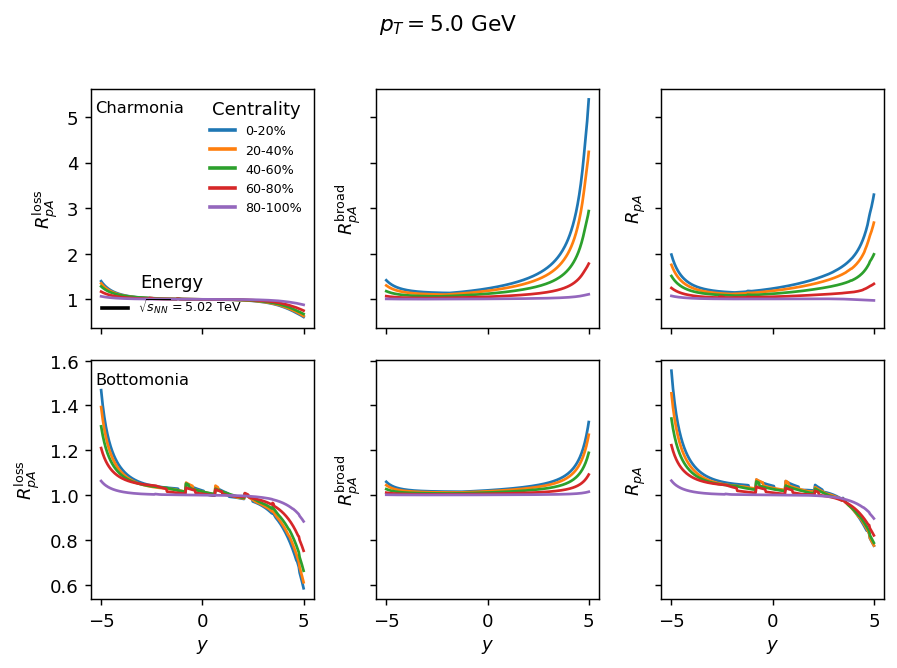

In [9]:
pT_fix = 5.0 
fig, axes = make_RpA_vs_y_2row(
    P_charmonia, P_bottomonia,
    roots5, roots8, QP5_base, QP8_base,
    Leff_5, Leff_8,
    y_grid, pT_fix,
    tags_order, colors,
    include_5=True, include_8=False,
)

In [10]:
# pT_fix = 10.0
# fig, axes = make_RpA_vs_y_2row(
#     P_charmonia, P_bottomonia,
#     roots5, roots8, QP5_base, QP8_base,
#     Leff_5, Leff_8,
#     y_grid, pT_fix,
#     tags_order, colors,
#     include_5=True, include_8=False,
# )

In [11]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D # Needed for the legend handles

# NOTE: The actual implementation of 'curves_vs_pT' and the definition
# of all other variables are assumed to be defined elsewhere.

def make_RpA_vs_pT_2row(
    P_charmonia, P_bottomonia,
    roots5, roots8, QP5_base, QP8_base,
    Leff_5, Leff_8,
    pT_grid, y_fix,
    tags_order, colors,
    # New optional arguments, placed first as requested
    include_5=True, include_8=True,
):
    """
    Calculates and plots the nuclear modification factors (RpA) vs. transverse momentum (pT)
    for charmonia and bottomonia, comparing two different energies (5.02 and 8.16 TeV).

    2×3 subfigure:
      row 0: charmonia (R_loss, R_broad, R_tot) vs pT
      row 1: bottomonia (R_loss, R_broad, R_tot) vs pT
    solid  = 5 TeV, dashed = 8 TeV.
    """
    if not include_5 and not include_8:
        raise ValueError("Need at least one energy to plot.")

    # 1. Calculate curves for included energies
    res_ch_5 = res_bo_5 = res_ch_8 = res_bo_8 = None

    if include_5:
        # Note: assuming a default Ny_eloss and Nphi_broad in curves_vs_pT 
        # or that they are not needed for pT-scan function.
        res_ch_5 = curves_vs_pT(P_charmonia, roots5, QP5_base, Leff_5, pT_grid, y_fix)
        res_bo_5 = curves_vs_pT(P_bottomonia, roots5, QP5_base, Leff_5, pT_grid, y_fix)
    
    if include_8:
        res_ch_8 = curves_vs_pT(P_charmonia, roots8, QP8_base, Leff_8, pT_grid, y_fix)
        res_bo_8 = curves_vs_pT(P_bottomonia, roots8, QP8_base, Leff_8, pT_grid, y_fix)

    # 2. Setup Plot
    fig, axes = plt.subplots(
        2, 3, figsize=(7.0, 5.2), dpi=130,
        sharex=True, sharey='row'
    )
    ax_ch_loss, ax_ch_broad, ax_ch_tot = axes[0]
    ax_bo_loss, ax_bo_broad, ax_bo_tot = axes[1]

    # 3. Helper function for plotting a row (Charmonia or Bottomonia)
    def _plot_row(ax_loss, ax_broad, ax_tot, res5, res8, title):
        for tag in tags_order:
            col = colors[tag]
            
            # Plot 5.02 TeV (solid lines)
            if include_5 and res5 is not None:
                Rl5, Rb5, Rt5 = res5[tag]
                ax_loss.plot(pT_grid, Rl5, color=col, ls="-")
                ax_broad.plot(pT_grid, Rb5, color=col, ls="-")
                ax_tot.plot(pT_grid, Rt5, color=col, ls="-")
            
            # Plot 8.16 TeV (dashed lines)
            if include_8 and res8 is not None:
                Rl8, Rb8, Rt8 = res8[tag]
                ax_loss.plot(pT_grid, Rl8, color=col, ls="--")
                ax_broad.plot(pT_grid, Rb8, color=col, ls="--")
                ax_tot.plot(pT_grid, Rt8, color=col, ls="--")

        # Set axis labels and titles
        ax_loss.set_ylabel(r"$R^{\mathrm{loss}}_{pA}(p_T)$")
        ax_broad.set_ylabel(r"$R^{\mathrm{broad}}_{pA}(p_T)$")
        ax_tot.set_ylabel(r"$R_{pA}(p_T)$")
        # Use text for title placement to be consistent with original function style, 
        # or use set_title if preferred. I'll keep the text from the original for style consistency.
        # ax_loss.set_title(title, fontsize=10)
        ax_loss.text(0.02, 0.95, title, transform=ax_loss.transAxes,
                     ha="left", va="top", fontsize=9)


    # 4. Plot both rows
    _plot_row(ax_ch_loss, ax_ch_broad, ax_ch_tot,
              res_ch_5, res_ch_8, r"Charmonia")
    _plot_row(ax_bo_loss, ax_bo_broad, ax_bo_tot,
              res_bo_5, res_bo_8, r"Bottomonia")

    # 5. Final Plot Styling and Labels
    for ax in axes[1]: # Set x-label only for the bottom row
        ax.set_xlabel(r"$p_T$ [GeV]")

    for row in axes:
        for ax in row:
            ax.grid(False)

    # 6. Centrality Legend
    cent_handles = [
        Line2D([0], [0], color=colors[tag], lw=2, ls="-", label=tag)
        for tag in tags_order
    ]
    ax0 = ax_ch_loss
    leg1 = ax0.legend(handles=cent_handles, title="Centrality",
                      frameon=False, fontsize=7, loc="upper right")
    ax0.add_artist(leg1)

    # 7. Energy Legend (now conditional)
    energy_handles = []
    if include_5:
        energy_handles.append(Line2D([0], [0], color="k", lw=2, ls="-",
                label=r"$\sqrt{s_{NN}}=5.02$ TeV"))
    if include_8:
        energy_handles.append(Line2D([0], [0], color="k", lw=2, ls="--",
                label=r"$\sqrt{s_{NN}}=8.16$ TeV"))
        
    if energy_handles:
        # Note: The original code had two consecutive calls to ax0.legend(), which 
        # would overwrite the second legend unless explicitly managed. 
        # A common way to handle this is using add_artist().
        leg2 = ax0.legend(handles=energy_handles, title="Energy",
                         frameon=False, fontsize=7, loc="lower left")
        # No need for ax0.add_artist(leg2) if it's the second call, but I will
        # keep the pattern for consistency if your environment expects it.
        # However, to display both, you MUST add the first one back as an artist.
        
        # The original code's second legend call was missing a separate artist management.
        # We will assume you want both legends to display and use the structure from 
        # the original function provided for `make_RpA_vs_y_2row`.
        # I'll rely on the original structure (add_artist for the first, simple call for the second).
        
        # Correctly display the second legend (Energy)
        ax0.legend(handles=energy_handles, title="Energy",
                   frameon=False, fontsize=7, loc="lower left")

    # 8. Title and Layout
    fig.suptitle(rf"$y = {y_fix:.1f}$", y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    return fig, axes

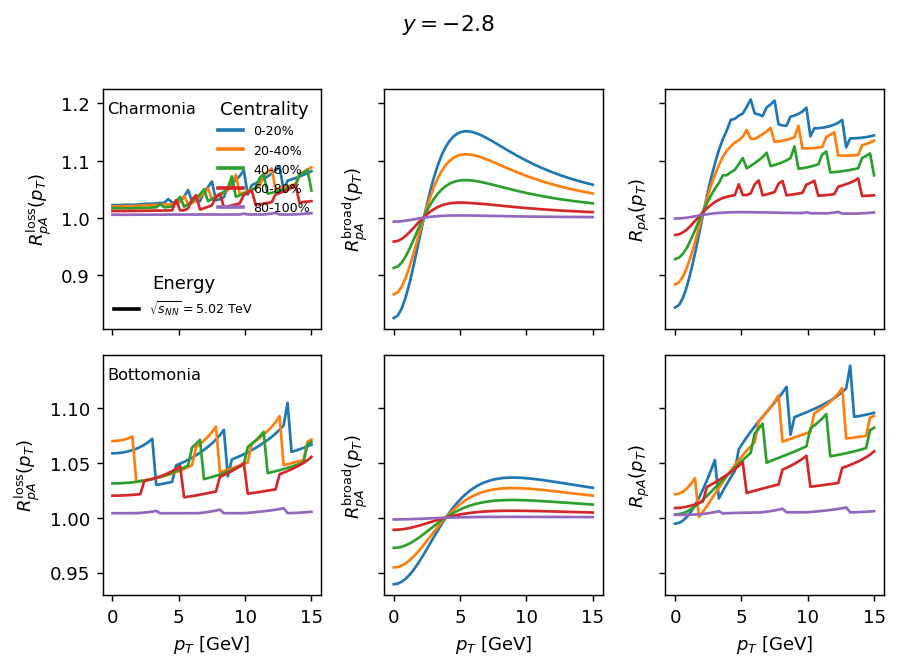

In [12]:
pT_grid = np.linspace(0.0, 15.0, 51)
y_fix   = -2.8
fig, axes = make_RpA_vs_pT_2row(
    P_charmonia, P_bottomonia,
    roots5, roots8, QP5_base, QP8_base,
    Leff_5, Leff_8,
    pT_grid, y_fix,
    tags_order, colors,
    include_5=True, include_8=False,
)

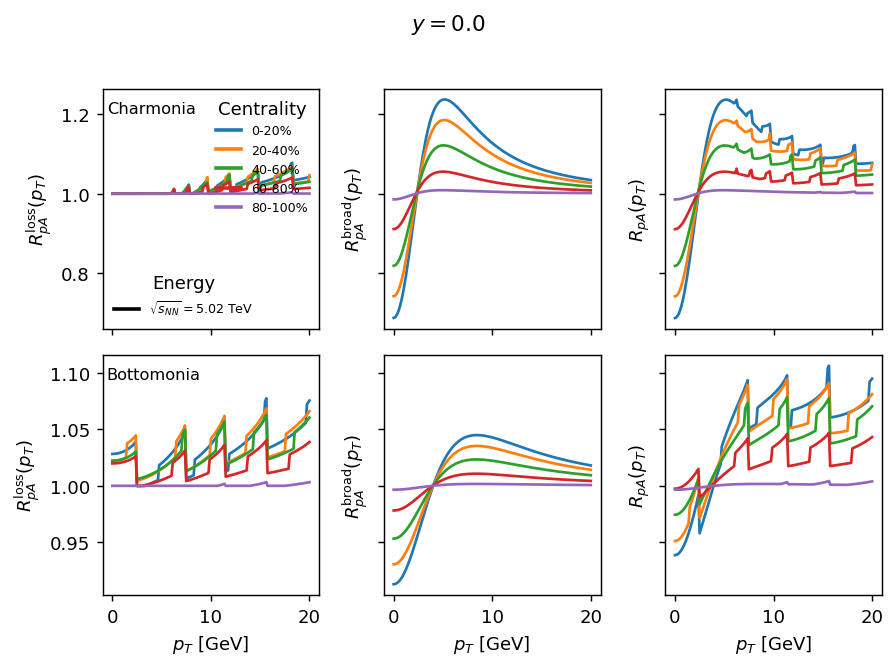

In [13]:
pT_grid = np.linspace(0.0, 20.0, 161)
y_fix   = 0
fig, axes = make_RpA_vs_pT_2row(
    P_charmonia, P_bottomonia,
    roots5, roots8, QP5_base, QP8_base,
    Leff_5, Leff_8,
    pT_grid, y_fix,
    tags_order, colors,
    include_5=True, include_8=False,
)

## $R^{eloss}_{pA}$, $R^{p_T \, broad}_{pA}$ & $R^{p_T \, eloss \times broad}_{pA}$ vs y and $p_T$ [Binned]

In [14]:
# -------------------------------------------------
# σ_pp weight from table or parametrization
# -------------------------------------------------
def _sigma_pp_weight(P, roots_GeV: float, table_or_none, y: float, pT: float) -> float:
    """
    σ_pp(y,pT;√s) used as weight.
    """
    if QF._HAS_TORCH and isinstance(table_or_none, QF.TorchSigmaPPTable):
        dev = table_or_none.device
        with torch.no_grad():
            y_t = torch.tensor([y],  dtype=torch.float64, device=dev)
            p_t = torch.tensor([pT], dtype=torch.float64, device=dev)
            return float(table_or_none(y_t, p_t)[0, 0].item())
    else:
        return float(P.d2sigma_pp(float(y), float(pT), float(roots_GeV)))

# ----------------------------------------------------------------
# <R> = (∫ dy dpT σ_pp(y_w,pT)·pT R) / (∫ dy dpT σ_pp(y_w,pT)·pT)
# ----------------------------------------------------------------
def R_binned_2D(
    R_func,                     # R_func(y,pT) -> float
    P, roots_GeV: float,
    y_range, pt_range,
    Ny_bin: int = 12, Npt_bin: int = 24,
    weight_kind: str = "pp",    # "pp" or "flat"
    table_for_pp=None,
    weight_ref_y: float | str = "local",
):
    """
    Generic bin average of R(y,pT) over y_range × pt_range.

      For weight_kind="pp":
        <R> = (∫ dy dpT σ_pp(y_w,pT)·pT R) / (∫ dy dpT σ_pp(y_w,pT)·pT)

      For weight_kind="flat":
        <R> = (∫ dy dpT R) / (∫ dy dpT 1)

      y_w = y if weight_ref_y == "local", else y_ref (float).
    """
    yl, yr = y_range
    pl, pr = pt_range

    y_nodes, y_w = QF._gl_nodes_np(yl, yr, Ny_bin)
    p_nodes, p_w = QF._gl_nodes_np(pl, pr, Npt_bin)

    if isinstance(weight_ref_y, str) and weight_ref_y.lower() == "local":
        y_ref = None
    else:
        y_ref = float(weight_ref_y)

    acc_num, acc_den = 0.0, 0.0

    for yi, wy in zip(y_nodes, y_w):
        y_for_w = float(yi) if y_ref is None else y_ref
        for pj, wp in zip(p_nodes, p_w):
            pj_f = float(pj)
            R    = float(R_func(float(yi), pj_f))

            if weight_kind == "pp":
                wgt = _sigma_pp_weight(P, roots_GeV, table_for_pp,
                                       y_for_w, pj_f)
                wgt *= max(pj_f, 1e-8)   # σ_pp·pT
            else:
                wgt = 1.0

            acc_num += wy * wp * R * wgt
            acc_den += wy * wp * wgt

    if acc_den <= 0:
        return acc_num
    return float(acc_num / acc_den)

### $R^{eloss}_{pA}$, $R^{p_T \, broad}_{pA}$ & $R^{p_T \, eloss \times broad}_{pA}$ vs y [BINNED]

In [15]:
# ---------- RpA(y) binned in y, integrated over pT ----------

def rpa_binned_vs_y(
    P, roots_GeV: float, qp_base,
    glauber, cent_bins,
    y_edges, pt_range,
    components=("total",),          # subset of {"loss","broad","total"}
    Ny_bin: int = 12, Npt_bin: int = 24,
    table_for_pp=None,
    weight_kind: str = "pp",        # "pp" or "flat"
    weight_ref_y: float | str = "local",
):
    """
    Returns y_centers, R_comp, labels.

    R_comp[comp][tag] for each centrality tag in labels
    and also R_comp[comp]["MB"] for min-bias (optical weights).
    """
    y_edges = np.asarray(y_edges, float)
    assert y_edges.ndim == 1 and y_edges.size >= 2
    Ny = y_edges.size - 1
    y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])

    comps  = list(components)
    labels = [f"{int(a)}-{int(b)}%" for (a,b) in cent_bins]

    L_by = glauber.leff_bins_pA(cent_bins, method="optical")
    Leff_dict = {lab: float(L_by[lab]) for lab in labels}

    # optical weights for MB
    w_bins = np.array(
        [QF._optical_bin_weight_pA(glauber, a, b) for (a,b) in cent_bins],
        float
    )
    w_bins = w_bins / max(w_bins.sum(), 1e-30)
    w_dict = {lab: w_bins[i] for i, lab in enumerate(labels)}

    R_comp = {comp: {lab: np.zeros(Ny, float) for lab in labels}
              for comp in comps}

    for i in range(Ny):
        y_range = (float(y_edges[i]), float(y_edges[i+1]))

        for lab in labels:
            L   = Leff_dict[lab]
            qpL = replace(qp_base, LA_fm=float(L))

            def R_loss(y, pT, qpL=qpL):
                return R_pA_eloss(P, roots_GeV, qpL, y, pT, Ny=None)

            def R_broad(y, pT, qpL=qpL):
                return R_pA_broad(P, roots_GeV, qpL, y, pT, Nphi=64)

            for comp in comps:
                if comp == "loss":
                    R_func = R_loss
                elif comp == "broad":
                    R_func = R_broad
                elif comp == "total":
                    def R_func(y, pT, qpL=qpL):
                        return R_loss(y, pT, qpL=qpL) * R_broad(y, pT, qpL=qpL)
                else:
                    raise ValueError("Unknown component")

                R_bar = R_binned_2D(
                    R_func, P, roots_GeV,
                    y_range, pt_range,
                    Ny_bin=Ny_bin, Npt_bin=Npt_bin,
                    weight_kind=weight_kind,
                    table_for_pp=table_for_pp,
                    weight_ref_y=weight_ref_y,
                )
                R_comp[comp][lab][i] = R_bar

    # min-bias
    for comp in comps:
        R_mat = np.vstack([R_comp[comp][lab] for lab in labels])  # (Ncent, Ny)
        w_arr = np.array([w_dict[lab] for lab in labels])
        R_MB  = np.average(R_mat, axis=0, weights=w_arr)
        R_comp[comp]["MB"] = R_MB

    return y_centers, R_comp, labels

# ## USAGE
# y_edges  = np.arange(-5.0, 5.0+0.5, 0.5)
# pt_range = (0.0, 15.0)

# y_cent, R_ch5, labels5 = rpa_binned_vs_y(
#     P_charmonia, roots5, QP5_base,
#     gl5, cent_bins,
#     y_edges, pt_range,
#     components=("loss","broad","total"),
#     Ny_bin=12, Npt_bin=24,
#     weight_kind="pp",        # or "flat"
#     weight_ref_y="local",
# )

In [16]:
y_edges  = np.arange(-5.0, 5.0+0.5, 0.5)
pt_range = (0.0, 15.0)

y_cent, R_ch5, labels5 = rpa_binned_vs_y(
    P_charmonia, roots5, QP5_base,
    gl5, cent_bins,
    y_edges, pt_range,
    components=("loss","broad","total"),
    Ny_bin=12, Npt_bin=24,
    weight_kind="pp",        # or "flat"
    weight_ref_y="local",
)

In [17]:
def plot_RpA_vs_y_binned(
    y_cent, R_dict, labels, component="total",
    show_MB=True, ax=None,
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5.0, 3.5), dpi=130)
    else:
        fig = ax.figure

    for lab in labels:
        if lab == "0-100%":
            continue
        R = R_dict[component][lab]
        ax.plot(y_cent, R, marker="o", ms=3, lw=1.2, label=lab)

    if show_MB and "MB" in R_dict[component]:
        Rmb = R_dict[component]["MB"]
        ax.plot(y_cent, Rmb, lw=2.0, ls="-", color="k", label="MB")
    ax.set_ylim(0.6,1.3)
    ax.set_xlabel(r"$y$")
    ax.set_ylabel(rf"$R^{{{component}}}_{{pA, \psi}}(y)$")
    ax.legend(frameon=False, fontsize=7)
    ax.grid(False)
    return fig, ax

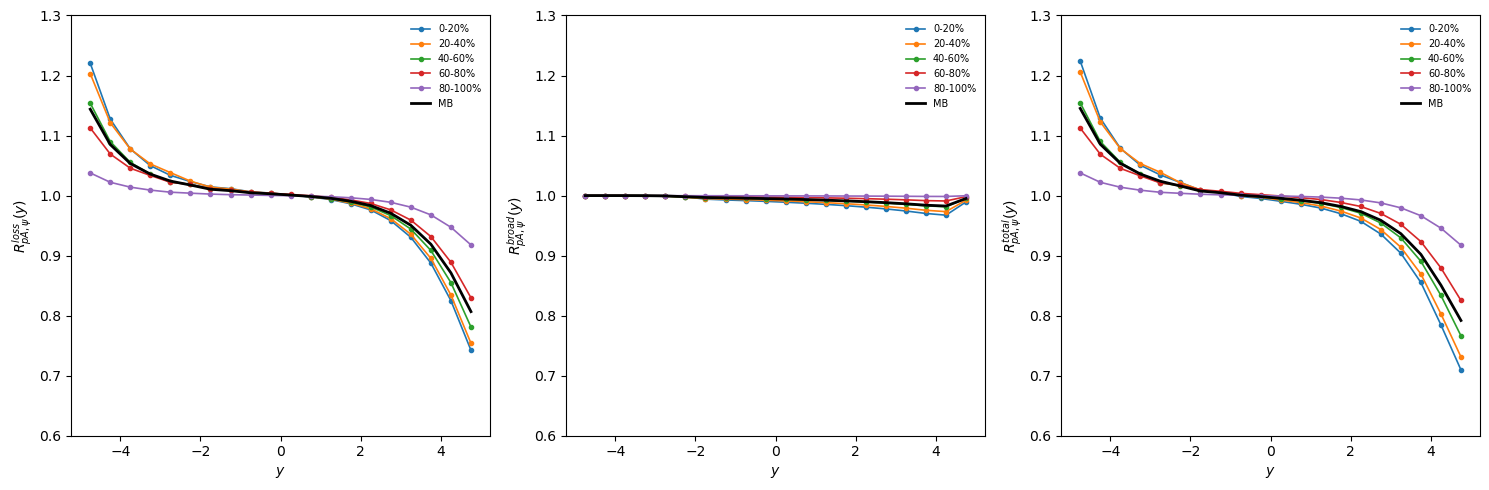

In [18]:
import matplotlib.pyplot as plt

# Step 1: Create the figure and a set of subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # Adjust figsize as needed

# Step 2: Generate the first plot (e.g., component="loss")
# Pass the first axis (axes[0]) to the plotting function.
plot_RpA_vs_y_binned(y_cent, R_ch5, labels=labels5, component="loss", ax=axes[0])

# Step 3: Generate the second plot (e.g., component="broad")
# Pass the second axis (axes[1]) to the plotting function.
plot_RpA_vs_y_binned(y_cent, R_ch5, labels=labels5, component="broad", ax=axes[1])

# Step 4: Generate the third plot (e.g., component="total")
# Pass the third axis (axes[2]) to the plotting function.
plot_RpA_vs_y_binned(y_cent, R_ch5, labels=labels5, component="total", ax=axes[2])

# Step 5: Adjust layout for better spacing and display the figure
fig.tight_layout()
plt.show()

### $R^{eloss}_{pA}$, $R^{p_T \, broad}_{pA}$ & $R^{p_T \, eloss \times broad}_{pA}$ vs $p_T$ [BINNED]

In [19]:

# ---------- RpA(pT) binned in pT, integrated over y ----------
def rpa_binned_vs_pT(
    P, roots_GeV: float, qp_base,
    glauber, cent_bins,
    pT_edges, y_range,
    components=("total",),
    Ny_bin: int = 12, Npt_bin: int = 24,
    table_for_pp=None,
    weight_kind: str = "pp",
    weight_ref_y: float | str = "local",
):
    """
    Same as rpa_binned_vs_y but swapping y ↔ pT roles.
    Returns pT_centers, R_comp, labels.
    """
    pT_edges = np.asarray(pT_edges, float)
    assert pT_edges.ndim == 1 and pT_edges.size >= 2
    Np = pT_edges.size - 1
    pT_centers = 0.5 * (pT_edges[:-1] + pT_edges[1:])

    comps  = list(components)
    labels = [f"{int(a)}-{int(b)}%" for (a,b) in cent_bins]

    L_by = glauber.leff_bins_pA(cent_bins, method="optical")
    Leff_dict = {lab: float(L_by[lab]) for lab in labels}

    w_bins = np.array(
        [QF._optical_bin_weight_pA(glauber, a, b) for (a,b) in cent_bins],
        float
    )
    w_bins = w_bins / max(w_bins.sum(), 1e-30)
    w_dict = {lab: w_bins[i] for i, lab in enumerate(labels)}

    R_comp = {comp: {lab: np.zeros(Np, float) for lab in labels}
              for comp in comps}

    for i in range(Np):
        pt_range = (float(pT_edges[i]), float(pT_edges[i+1]))

        for lab in labels:
            L   = Leff_dict[lab]
            qpL = replace(qp_base, LA_fm=float(L))

            def R_loss(y, pT, qpL=qpL):
                return R_pA_eloss(P, roots_GeV, qpL, y, pT, Ny=None)

            def R_broad(y, pT, qpL=qpL):
                return R_pA_broad(P, roots_GeV, qpL, y, pT, Nphi=64)

            for comp in comps:
                if comp == "loss":
                    R_func = R_loss
                elif comp == "broad":
                    R_func = R_broad
                elif comp == "total":
                    def R_func(y, pT, qpL=qpL):
                        return R_loss(y, pT, qpL=qpL) * R_broad(y, pT, qpL=qpL)
                else:
                    raise ValueError("Unknown component")

                R_bar = R_binned_2D(
                    R_func, P, roots_GeV,
                    y_range, pt_range,
                    Ny_bin=Ny_bin, Npt_bin=Npt_bin,
                    weight_kind=weight_kind,
                    table_for_pp=table_for_pp,
                    weight_ref_y=weight_ref_y,
                )
                R_comp[comp][lab][i] = R_bar

    for comp in comps:
        R_mat = np.vstack([R_comp[comp][lab] for lab in labels])  # (Ncent, Np)
        w_arr = np.array([w_dict[lab] for lab in labels])
        R_MB  = np.average(R_mat, axis=0, weights=w_arr)
        R_comp[comp]["MB"] = R_MB

    return pT_centers, R_comp, labels

## Usage
# pT_edges = np.arange(0.0, 15.0+2.5, 2.5)
# y_range  = (-3.0, -2.0)

# pT_cent, R_ch5_pT, labels5_pT = rpa_binned_vs_pT(
#     P_charmonia, roots5, QP5_base,
#     gl5, cent_bins,
#     pT_edges, y_range,
#     components=("loss","broad","total"),
#     Ny_bin=12, Npt_bin=24,
#     weight_kind="pp",
#     weight_ref_y="local",
# )

In [20]:
## pt plotting
def plot_RpA_vs_pT_binned(
    pT_cent, R_dict, labels, component="total",
    show_MB=True, ax=None
):
    """
    Plots the Nuclear Modification Factor (RpA) vs. transverse momentum (pT)
    for different centrality bins.

    Parameters:
        pT_cent (array): The center values of the pT bins (x-axis data).
        R_dict (dict): A dictionary containing the RpA values for different
                       components ("loss", "broad", "total") and centrality labels.
        labels (list): List of centrality labels (e.g., ["0-10%", "10-20%"]).
        component (str): Which component to plot ("loss", "broad", or "total").
        show_MB (bool): Whether to include the Minimum Bias (MB) data.
        ax (matplotlib.axes.Axes, optional): The axes object to plot on.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(5.0, 3.5), dpi=130)
    else:
        fig = ax.figure

    # Plot each centrality bin
    for lab in labels:
        if lab == "0-100%": # Skip the 0-100% label if it's already represented by MB
            continue
        # Ensure the key exists before accessing
        if lab in R_dict[component]:
            R = R_dict[component][lab]
            ax.plot(pT_cent, R, marker="o", ms=3, lw=1.2, label=lab)

    # Plot Minimum Bias (MB) if requested and available
    if show_MB and "MB" in R_dict[component]:
        Rmb = R_dict[component]["MB"]
        ax.plot(pT_cent, Rmb, lw=2.0, ls="-", color="k", label="MB")

    # Set pT-specific axis labels
    ax.set_xlabel(r"$p_T$ [GeV]")
    ax.set_ylabel(r"$R_{pA}(p_T)$")
    
    # Set x-axis to log scale for better visualization of pT data range
    # ax.set_xscale('log') 

    ax.legend(frameon=False, fontsize=7)
    ax.grid(False)
    return fig, ax

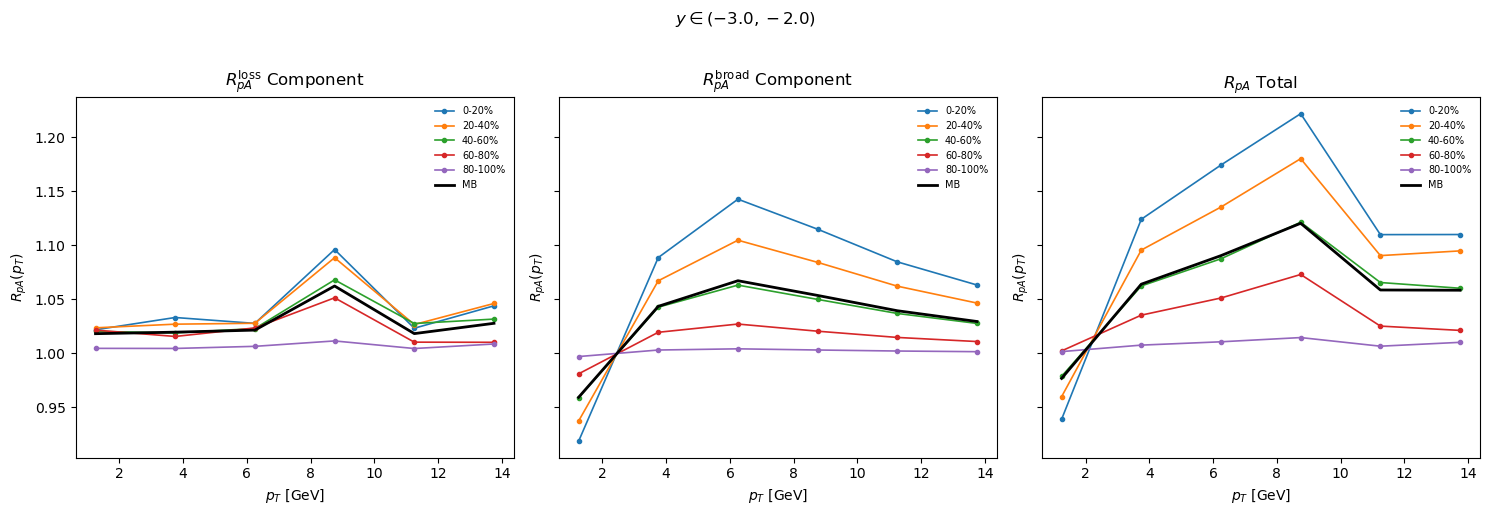

In [21]:
pT_edges = np.arange(0.0, 15.0+2.5, 2.5)
y_range  = (-3.0, -2.0)

pT_cent, R_ch5_pT, labels5_pT = rpa_binned_vs_pT(
    P_charmonia, roots5, QP5_base,
    gl5, cent_bins,
    pT_edges, y_range,
    components=("loss","broad","total"),
    Ny_bin=12, Npt_bin=24,
    weight_kind="pp",
    weight_ref_y="local",
)

# Step 1: Create the figure and a set of subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True) 

# Step 2: Generate the first plot (component="loss")
plot_RpA_vs_pT_binned(pT_cent, R_ch5_pT, labels5_pT, component="loss", ax=axes[0])
axes[0].set_title(r"$R^{\mathrm{loss}}_{pA}$ Component")

# Step 3: Generate the second plot (component="broad")
plot_RpA_vs_pT_binned(pT_cent, R_ch5_pT, labels5_pT, component="broad", ax=axes[1])
axes[1].set_title(r"$R^{\mathrm{broad}}_{pA}$ Component")

# Step 4: Generate the third plot (component="total")
plot_RpA_vs_pT_binned(pT_cent, R_ch5_pT, labels5_pT, component="total", ax=axes[2])
axes[2].set_title(r"$R_{pA}$ Total")

# Step 5: Adjust layout for better spacing and display the figure
fig.suptitle(rf"$y \in ({y_range[0]:.1f}, {y_range[1]:.1f})$", y=1.02)
fig.tight_layout()
plt.show()

## $R^{eloss}_{pA}$, $R^{p_T \, broad}_{pA}$ & $R^{p_T \, eloss \times broad}_{pA}$ vs y and $p_T$ [Binned + BAND]

### $R^{eloss}_{pA}$, $R^{p_T \, broad}_{pA}$ & $R^{p_T \, eloss \times broad}_{pA}$ vs y [Binned + BAND]

In [22]:
## NOW BINNED + BAND RESULTS: for eloss use q0 pair (0.05 and 0.09), and for broadening we can take p0 (
# ---------- generic two-point band helper ----------
def _two_point_band(R_lo: np.ndarray, R_hi: np.ndarray):
    """
    Given arrays R(q_min) and R(q_max), return
      Rc, Rlow, Rhigh  with symmetric error.
    """
    Rc = 0.5 * (R_lo + R_hi)
    dR = 0.5 * np.abs(R_hi - R_lo)
    return Rc, Rc - dR, Rc + dR


def combine_factorized_bands_1d(RL_c, RL_lo, RL_hi,
                                RB_c, RB_lo, RB_hi):
    """
    Combine loss & broad bands into total, assuming factorisation:

      R_tot = R_L * R_B
      (δR_tot / R_tot)^2 = (δR_L / R_L)^2 + (δR_B / R_B)^2.

    Inputs:
      RL_* and RB_* : dict[tag] -> array (or scalar)

    Returns:
      RT_c, RT_lo, RT_hi : dict[tag] -> array (or scalar)
    """
    RT_c, RT_lo, RT_hi = {}, {}, {}
    for lab in RL_c.keys():
        Lc  = np.asarray(RL_c[lab])
        Llo = np.asarray(RL_lo[lab])
        Lhi = np.asarray(RL_hi[lab])

        Bc  = np.asarray(RB_c[lab])
        Blo = np.asarray(RB_lo[lab])
        Bhi = np.asarray(RB_hi[lab])

        dL = 0.5*np.abs(Lhi - Llo)
        dB = 0.5*np.abs(Bhi - Blo)

        Lc_safe = np.where(np.abs(Lc) > 1e-12, Lc, 1.0)
        Bc_safe = np.where(np.abs(Bc) > 1e-12, Bc, 1.0)

        Rc   = Lc * Bc
        rel2 = (dL/Lc_safe)**2 + (dB/Bc_safe)**2
        dR   = Rc * np.sqrt(rel2)

        RT_c[lab], RT_lo[lab], RT_hi[lab] = Rc, Rc - dR, Rc + dR

    return RT_c, RT_lo, RT_hi

### Band vs y plot
## eloss band from q0 pair
def rpa_band_vs_y_eloss(
    P, roots_GeV: float,
    qp_base,
    glauber, cent_bins,
    y_edges, pt_range,
    q0_pair=(0.05, 0.09),
    Ny_bin: int = 12, Npt_bin: int = 24,
    weight_kind: str = "pp",
    weight_ref_y: float | str = "local",
    table_for_pp=None,
):
    """
    Binned R_pA^loss(y) band from q0_pair.

    Returns
    -------
      y_cent
      RL_c[lab], RL_lo[lab], RL_hi[lab]   (lab includes "MB")
      labels   (centrality labels)
    """
    q0_lo, q0_hi = q0_pair
    qp_lo = replace(qp_base, qhat0=float(q0_lo))
    qp_hi = replace(qp_base, qhat0=float(q0_hi))

    y_cent_lo, R_lo, labels = rpa_binned_vs_y(
        P, roots_GeV, qp_lo,
        glauber, cent_bins,
        y_edges, pt_range,
        components=("loss",),
        Ny_bin=Ny_bin, Npt_bin=Npt_bin,
        table_for_pp=table_for_pp,
        weight_kind=weight_kind,
        weight_ref_y=weight_ref_y,
    )
    y_cent_hi, R_hi, _ = rpa_binned_vs_y(
        P, roots_GeV, qp_hi,
        glauber, cent_bins,
        y_edges, pt_range,
        components=("loss",),
        Ny_bin=Ny_bin, Npt_bin=Npt_bin,
        table_for_pp=table_for_pp,
        weight_kind=weight_kind,
        weight_ref_y=weight_ref_y,
    )
    assert np.allclose(y_cent_lo, y_cent_hi)
    y_cent = y_cent_lo

    RL_c, RL_lo, RL_hi = {}, {}, {}
    for lab in R_lo["loss"].keys():   # cent bins + "MB"
        Rc, Rl, Rh = _two_point_band(R_lo["loss"][lab], R_hi["loss"][lab])
        RL_c[lab], RL_lo[lab], RL_hi[lab] = Rc, Rl, Rh

    return y_cent, RL_c, RL_lo, RL_hi, labels

## broad band from p0-scale
def rpa_band_vs_y_broad(
    P, roots_GeV: float,
    qp_base,
    glauber, cent_bins,
    y_edges, pt_range,
    p0_scale_pair=(0.9, 1.1),
    Ny_bin: int = 12, Npt_bin: int = 24,
    weight_kind: str = "pp",
    weight_ref_y: float | str = "local",
    table_for_pp=None,
):
    """
    Binned R_pA^broad(y) band from scaling p0 in the pp spectrum.

    Returns
    -------
      y_cent
      RB_c[lab], RB_lo[lab], RB_hi[lab]
      labels
    """
    P_lo = particle_with_scaled_p0(P, p0_scale_pair[0])
    P_hi = particle_with_scaled_p0(P, p0_scale_pair[1])

    y_cent_lo, R_lo, labels = rpa_binned_vs_y(
        P_lo, roots_GeV, qp_base,
        glauber, cent_bins,
        y_edges, pt_range,
        components=("broad",),
        Ny_bin=Ny_bin, Npt_bin=Npt_bin,
        table_for_pp=table_for_pp,
        weight_kind=weight_kind,
        weight_ref_y=weight_ref_y,
    )
    y_cent_hi, R_hi, _ = rpa_binned_vs_y(
        P_hi, roots_GeV, qp_base,
        glauber, cent_bins,
        y_edges, pt_range,
        components=("broad",),
        Ny_bin=Ny_bin, Npt_bin=Npt_bin,
        table_for_pp=table_for_pp,
        weight_kind=weight_kind,
        weight_ref_y=weight_ref_y,
    )
    assert np.allclose(y_cent_lo, y_cent_hi)
    y_cent = y_cent_lo

    RB_c, RB_lo, RB_hi = {}, {}, {}
    for lab in R_lo["broad"].keys():
        Rc, Rl, Rh = _two_point_band(R_lo["broad"][lab], R_hi["broad"][lab])
        RB_c[lab], RB_lo[lab], RB_hi[lab] = Rc, Rl, Rh

    return y_cent, RB_c, RB_lo, RB_hi, labels


def rpa_band_vs_y(
    P, roots_GeV: float,
    qp_base,
    glauber, cent_bins,
    y_edges, pt_range,
    components=("loss","broad","total"),
    q0_pair=(0.05, 0.09),
    p0_scale_pair=(0.9, 1.1),
    Ny_bin: int = 12, Npt_bin: int = 24,
    weight_kind: str = "pp",
    weight_ref_y: float | str = "local",
    table_for_pp=None,
):
    """
    Full RpA band vs y:

      • eloss band from q0_pair
      • broad band from p0_scale_pair
      • total band from factorised combination in quadrature.

    Returns
    -------
      y_cent           : 1D array (bin centres)
      bands            : dict[component] -> (Rc, Rlo, Rhi) where each is dict[tag]->array
      labels           : list of centrality labels (same as from rpa_binned_vs_y)
    """
    # ---- eLoss band (q0) ----
    y_cent, RL_c, RL_lo, RL_hi, labels = rpa_band_vs_y_eloss(
        P, roots_GeV, qp_base,
        glauber, cent_bins,
        y_edges, pt_range,
        q0_pair=q0_pair,
        Ny_bin=Ny_bin, Npt_bin=Npt_bin,
        weight_kind=weight_kind,
        weight_ref_y=weight_ref_y,
        table_for_pp=table_for_pp,
    )

    # ---- broad band (p0) ----
    y_cent2, RB_c, RB_lo, RB_hi, labels_b = rpa_band_vs_y_broad(
        P, roots_GeV, qp_base,
        glauber, cent_bins,
        y_edges, pt_range,
        p0_scale_pair=p0_scale_pair,
        Ny_bin=Ny_bin, Npt_bin=Npt_bin,
        weight_kind=weight_kind,
        weight_ref_y=weight_ref_y,
        table_for_pp=table_for_pp,
    )
    assert np.allclose(y_cent, y_cent2)

    # ---- total band from loss ⊗ broad ----
    RT_c, RT_lo, RT_hi = combine_factorized_bands_1d(
        RL_c, RL_lo, RL_hi,
        RB_c, RB_lo, RB_hi,
    )

    bands: dict[str, tuple[dict,dict,dict]] = {}
    if "loss" in components:
        bands["loss"] = (RL_c, RL_lo, RL_hi)
    if "broad" in components:
        bands["broad"] = (RB_c, RB_lo, RB_hi)
    if "total" in components:
        bands["total"] = (RT_c, RT_lo, RT_hi)

    return y_cent, bands, labels

In [23]:
## Plotting Helper, stepify centres → edges
def _step_from_centers(x_cent, vals):
    """
    Given bin centers x_cent and values vals (same length, uniform spacing),
    build (x_edges, y_step) so that

        plt.step(x_edges, y_step, where="post")

    gives a flat segment per bin.

    Assumes constant bin width.
    """
    x_cent = np.asarray(x_cent, float)
    vals   = np.asarray(vals, float)
    assert x_cent.size == vals.size

    if x_cent.size > 1:
        dx = np.diff(x_cent)
        dx0 = dx[0]
        if not np.allclose(dx, dx0):
            raise ValueError("x_cent not uniformly spaced – can't stepify safely.")
    else:
        # single bin; choose arbitrary width 1
        dx0 = 1.0

    x_edges = np.concatenate(([x_cent[0] - 0.5*dx0],
                              x_cent + 0.5*dx0))
    y_step  = np.concatenate([vals, vals[-1:]])
    return x_edges, y_step

In [24]:
def plot_RpA_vs_y_band(
    y_cent, Rc_dict, Rlow_dict, Rhigh_dict,
    tags_order,
    component_label=r"$R_{pA}(y)$",
    ax=None,
    step: bool = True,
    note: str | None = None,
):
    """
    RpA vs y with bands for each centrality + MB.

    Parameters
    ----------
    y_cent        : 1D array of bin centres.
    Rc_dict       : dict[tag] -> central values (1D array).
    Rlow_dict     : dict[tag] -> lower edge of band.
    Rhigh_dict    : dict[tag] -> upper edge of band.
    tags_order    : list of centrality tags for plotting order.
    step          : if True, draw step-style (bin-wise) curves & bands;
                    if False, draw smooth line/band at the centres.
    note          : optional text shown inside the panel (e.g. pT range).
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(5.0, 3.5), dpi=130)
    else:
        fig = ax.figure

    for tag in tags_order:
        Rc  = np.asarray(Rc_dict[tag])
        Rlo = np.asarray(Rlow_dict[tag])
        Rhi = np.asarray(Rhigh_dict[tag])
        col = colors[tag]

        if step:
            x_edges, y_c  = _step_from_centers(y_cent, Rc)
            _,       y_lo = _step_from_centers(y_cent, Rlo)
            _,       y_hi = _step_from_centers(y_cent, Rhi)

            ax.step(x_edges, y_c, where="post", color=col, lw=1.5, label=tag)
            ax.fill_between(x_edges, y_lo, y_hi,
                            step="post", color=col, alpha=0.25, linewidth=0.0)
        else:
            ax.plot(y_cent, Rc, color=col, lw=1.5, label=tag)
            ax.fill_between(y_cent, Rlo, Rhi,
                            color=col, alpha=0.25, linewidth=0.0)

    # MB as thick black line + grey band
    if "MB" in Rc_dict:
        Rc  = np.asarray(Rc_dict["MB"])
        Rlo = np.asarray(Rlow_dict["MB"])
        Rhi = np.asarray(Rhigh_dict["MB"])

        if step:
            x_edges, y_c  = _step_from_centers(y_cent, Rc)
            _,       y_lo = _step_from_centers(y_cent, Rlo)
            _,       y_hi = _step_from_centers(y_cent, Rhi)

            ax.step(x_edges, y_c, where="post", color="k", lw=2.0, label="MB")
            ax.fill_between(x_edges, y_lo, y_hi,
                            step="post", color="gray", alpha=0.30, linewidth=0.0)
        else:
            ax.plot(y_cent, Rc, color="k", lw=2.0, label="MB")
            ax.fill_between(y_cent, Rlo, Rhi,
                            color="gray", alpha=0.30, linewidth=0.0)

    ax.axhline(1.0, color="k", ls=":", lw=0.8)
    ax.set_xlabel(r"$y$")
    ax.set_ylabel(component_label)
    ax.legend(frameon=False, fontsize=7, ncol=2)
    ax.grid(False)

    if note is not None:
        ax.text(
            0.03, 0.97, note,
            transform=ax.transAxes,
            fontsize=8,
            va="top", ha="left",
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.7),
        )

    return fig, ax

In [25]:
# y_edges  = np.arange(-5.0, 5.0+0.5, 0.5)
# pt_range = (0.0, 15.0)

# y_cent, bands, labels = rpa_band_vs_y(
#     P_charmonia, roots5, QP5_base,
#     gl5, cent_bins,
#     y_edges, pt_range,
#     components=("total",),
#     q0_pair=Q0_PAIR,
#     p0_scale_pair=(0.9, 1.1),
#     Ny_bin=12, Npt_bin=24,
#     weight_kind="pp",
#     weight_ref_y="local",
# )

# RT_c, RT_lo, RT_hi = bands["total"]
# note = rf"$p_T\in[{pt_range[0]:.1f},{pt_range[1]:.1f}]$ GeV"

# fig, ax = plot_RpA_vs_y_band(
#     y_cent, RT_c, RT_lo, RT_hi,
#     tags_order,
#     component_label=r"$R^{\rm eloss\times broad}_{pA}(y)$",
#     step=True,
#     note=note,
# )
# fig.tight_layout()
# plt.savefig(f'R_eloss_broad_pA_vs_y_charmonia_5TeV_pT({pt_range[0]:.1f},{pt_range[1]:.1f}).pdf', dpi=300, bbox_inches='tight')

In [26]:
# y_edges  = np.arange(-5.0, 5.0+0.5, 0.5)
# pt_range = (0.0, 15.0)

# y_cent, bands, labels = rpa_band_vs_y(
#     P_charmonia, roots5, QP5_base,
#     gl5, cent_bins,
#     y_edges, pt_range,
#     components=("broad",),
#     q0_pair=Q0_PAIR,
#     p0_scale_pair=(0.9, 1.1),
#     Ny_bin=12, Npt_bin=24,
#     weight_kind="pp",
#     weight_ref_y="local",
# )

# RT_c, RT_lo, RT_hi = bands["broad"]
# note = rf"$p_T\in[{pt_range[0]:.1f},{pt_range[1]:.1f}]$ GeV"

# fig, ax = plot_RpA_vs_y_band(
#     y_cent, RT_c, RT_lo, RT_hi,
#     tags_order,
#     component_label=r"$R^{\rm broad}_{pA}(y)$",
#     step=True,
#     note=note,
# )
# fig.tight_layout()
# plt.savefig(f'R_broad_pA_vs_y_charmonia_5TeV_pT({pt_range[0]:.1f},{pt_range[1]:.1f}).pdf', dpi=300, bbox_inches='tight')

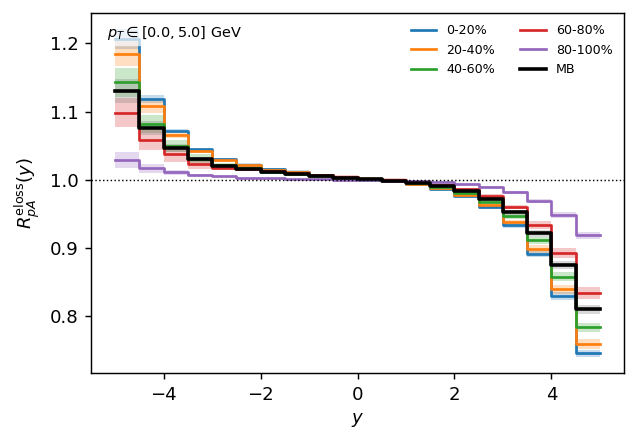

In [27]:
y_edges  = np.arange(-5.0, 5.0+0.5, 0.5)
pt_range = (0.0, 5.0)

y_cent, bands, labels = rpa_band_vs_y(
    P_charmonia, roots5, QP5_base,
    gl5, cent_bins,
    y_edges, pt_range,
    components=("loss",),
    q0_pair=Q0_PAIR,
    p0_scale_pair=(0.9, 1.1),
    Ny_bin=12, Npt_bin=24,
    weight_kind="pp",
    weight_ref_y="local",
)

RT_c, RT_lo, RT_hi = bands["loss"]
note = rf"$p_T\in[{pt_range[0]:.1f},{pt_range[1]:.1f}]$ GeV"

fig, ax = plot_RpA_vs_y_band(
    y_cent, RT_c, RT_lo, RT_hi,
    tags_order,
    component_label=r"$R^{\rm eloss}_{pA}(y)$",
    step=True,
    note=note,
)
fig.tight_layout()
plt.savefig(f'R_eloss_pA_vs_y_charmonia_5TeV_pT({pt_range[0]:.1f},{pt_range[1]:.1f}).pdf', dpi=300, bbox_inches='tight')

In [28]:
def plot_RpA_vs_y_components_per_centrality(
    P, roots_GeV, qp_base,
    glauber, cent_bins,
    y_edges, pt_range,
    show_components=("loss", "broad", "total"),
    q0_pair=(0.05, 0.09),
    p0_scale_pair=(0.9, 1.1),
    Ny_bin: int = 12, Npt_bin: int = 24,
    weight_kind: str = "pp",
    weight_ref_y: float | str = "local",
    include_MB: bool = True,
    ncols: int = 3,
    step: bool = True,
    suptitle: str | None = None,
):
    """
    Make a grid of subplots, one per centrality bin (+ optional MB),
    with different components (loss, broad, total) shown as
    different colours + legend entries.

    Layout:
        panels = centralities (and optional MB),
        curves  = components in show_components.
    """
    # Get only the components we actually need
    comp_list = tuple(sorted(set(show_components)))
    y_cent, bands, labels = rpa_band_vs_y(
        P, roots_GeV, qp_base,
        glauber, cent_bins,
        y_edges, pt_range,
        components=comp_list,
        q0_pair=q0_pair,
        p0_scale_pair=p0_scale_pair,
        Ny_bin=Ny_bin, Npt_bin=Npt_bin,
        weight_kind=weight_kind,
        weight_ref_y=weight_ref_y,
    )

    # Which centrality tags to show as panels
    cent_tags = [f"{a}-{b}%" for (a, b) in cent_bins if (a, b) != (0, 100)]
    if include_MB:
        # add MB if present in bands
        any_comp = next(iter(bands.values()))
        Rc_dict_any = any_comp[0]
        if "MB" in Rc_dict_any:
            cent_tags.append("MB")

    # Colours & labels per component (consistent across panels)
    comp_colors = {
        "loss":  "C0",
        "broad": "C1",
        "total": "C3",
    }
    comp_labels = {
        "loss":  r"eloss",
        "broad": r"$p_T$ broad.",
        "total": r"eloss $\times$ $p_T$ broad.",
    }

    # Common pT-range note
    note = rf"$p_T\in[{pt_range[0]:.1f},{pt_range[1]:.1f}]$ GeV"

    # Figure / axes
    n_panels = len(cent_tags)
    ncols = min(ncols, n_panels)
    nrows = int(np.ceil(n_panels / ncols))

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(4.0 * ncols, 3.2 * nrows),
        dpi=130,
        sharey=True,
    )
    axes = np.atleast_1d(axes).ravel()

    for iax, (ax, tag) in enumerate(zip(axes, cent_tags)):
        for comp in show_components:
            Rc_dict, Rlo_dict, Rhi_dict = bands[comp]
            Rc  = np.asarray(Rc_dict[tag])
            Rlo = np.asarray(Rlo_dict[tag])
            Rhi = np.asarray(Rhi_dict[tag])

            col   = comp_colors.get(comp, "k")
            label = comp_labels.get(comp, comp) if iax == 0 else None

            if step:
                x_edges, y_c  = _step_from_centers(y_cent, Rc)
                _,       y_lo = _step_from_centers(y_cent, Rlo)
                _,       y_hi = _step_from_centers(y_cent, Rhi)

                ax.step(x_edges, y_c, where="post",
                        color=col, lw=1.6, label=label)
                ax.fill_between(
                    x_edges, y_lo, y_hi,
                    step="post", color=col, alpha=0.25, linewidth=0.0
                )
            else:
                ax.plot(y_cent, Rc, color=col, lw=1.6, label=label)
                ax.fill_between(
                    y_cent, Rlo, Rhi,
                    color=col, alpha=0.25, linewidth=0.0
                )

        # Horizontal R=1 line
        ax.axhline(1.0, color="k", ls=":", lw=0.8)

        # Panel title = centrality / MB
        if tag == "MB":
            ax.set_title("MB", fontsize=9)
        else:
            ax.set_title(tag, fontsize=9)

        # y-label only on leftmost panels
        if iax % ncols == 0:
            ax.set_ylabel(r"$R_{pA}(y)$")

        ax.set_xlabel(r"$y$")
        ax.grid(False)

        # Note inside each panel
        ax.text(
            0.03, 0.97, note,
            transform=ax.transAxes,
            fontsize=8,
            va="top", ha="left",
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.7),
        )

        # Only first axis gets the legend
        if iax == 0:
            ax.legend(frameon=False, fontsize=7, loc="lower left")

    # Remove any unused axes (if n_panels < nrows*ncols)
    for j in range(n_panels, len(axes)):
        fig.delaxes(axes[j])

    if suptitle is not None:
        fig.suptitle(suptitle, y=0.99)
    plt.xlim(-5.0,5.0)
    fig.tight_layout(rect=[0, 0, 1, 0.96] if suptitle else None)
    return fig, axes


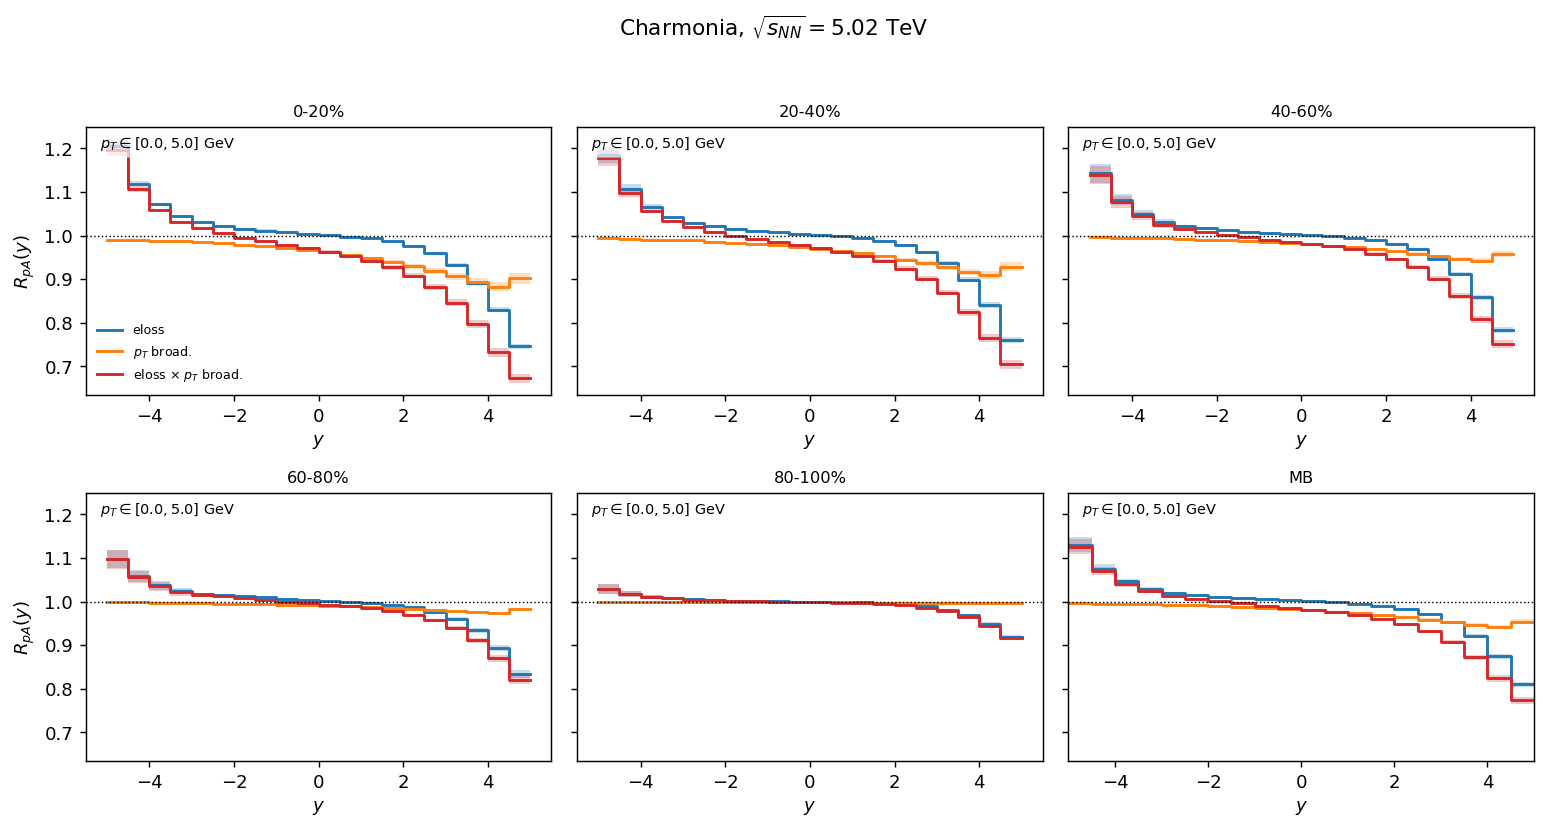

In [29]:
y_edges  = np.arange(-5.0, 5.0+0.5, 0.5)
pt_range = (0.0, 5.0)

fig, axes = plot_RpA_vs_y_components_per_centrality(
    P_charmonia, roots5, QP5_base,
    gl5, cent_bins,
    y_edges, pt_range,
    show_components=("loss", "broad", "total"),
    q0_pair=Q0_PAIR,
    p0_scale_pair=(0.9, 1.1),
    Ny_bin=12, Npt_bin=24,
    weight_kind="pp",
    weight_ref_y="local",
    include_MB=True,
    ncols=3,
    step=True,
    suptitle=r"Charmonia, $\sqrt{s_{NN}}=5.02$ TeV",
)

plt.savefig(
    "RpA_vs_y_components_by_centrality_charmonia_5TeV.pdf",
    dpi=300, bbox_inches="tight"
)

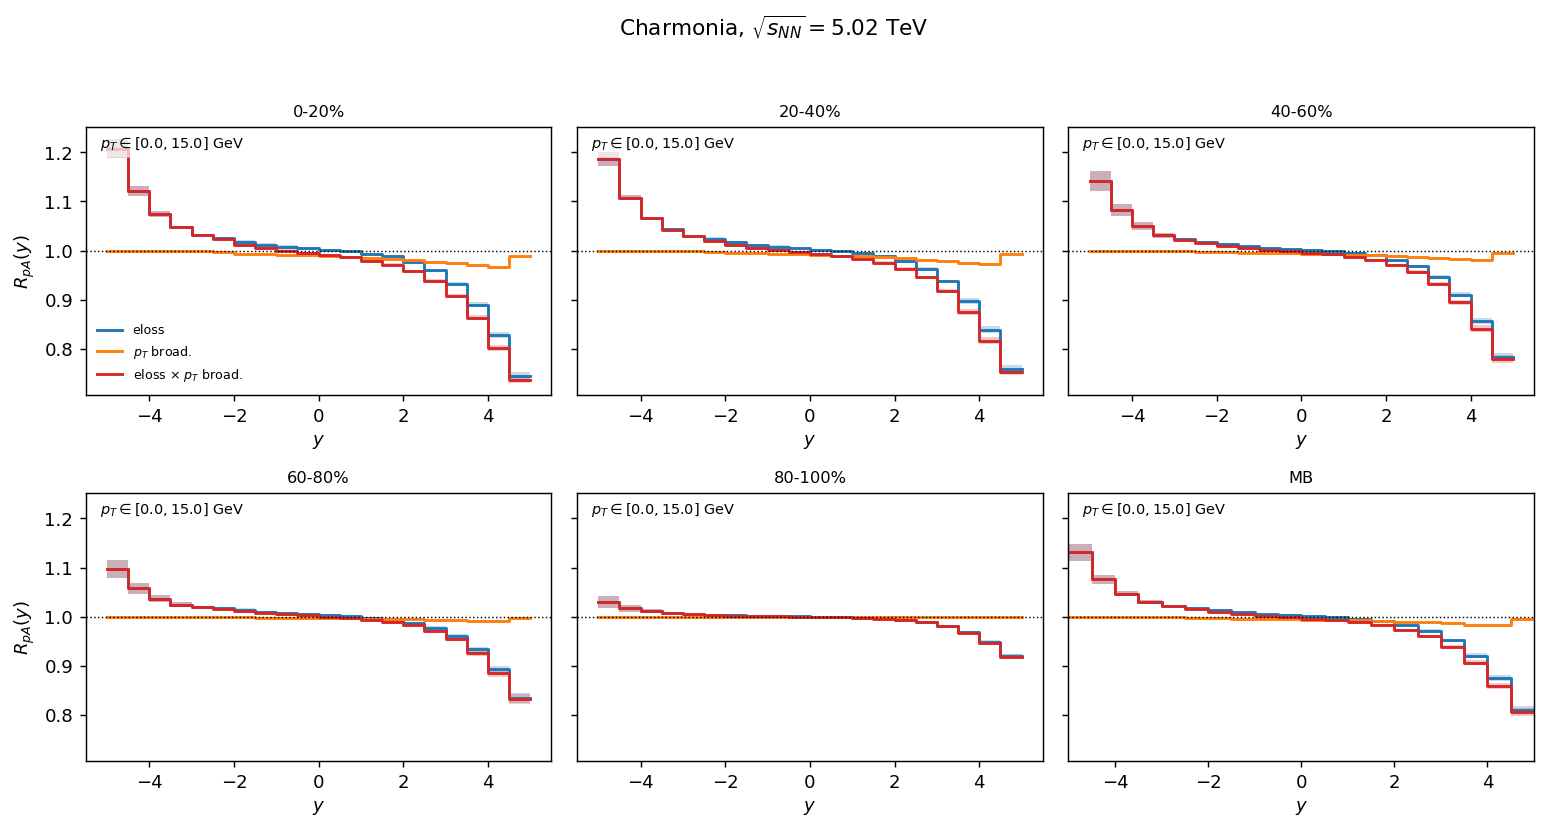

In [30]:
y_edges  = np.arange(-5.0, 5.0+0.5, 0.5)
pt_range = (0.0, 15.0)

fig, axes = plot_RpA_vs_y_components_per_centrality(
    P_charmonia, roots5, QP5_base,
    gl5, cent_bins,
    y_edges, pt_range,
    show_components=("loss", "broad", "total"),
    q0_pair=Q0_PAIR,
    p0_scale_pair=(0.9, 1.1),
    Ny_bin=12, Npt_bin=24,
    weight_kind="pp",
    weight_ref_y="local",
    include_MB=True,
    ncols=3,
    step=True,
    suptitle=r"Charmonia, $\sqrt{s_{NN}}=5.02$ TeV",
)

plt.savefig(
    "RpA_vs_y_components_by_centrality_charmonia_5TeV.pdf",
    dpi=300, bbox_inches="tight"
)

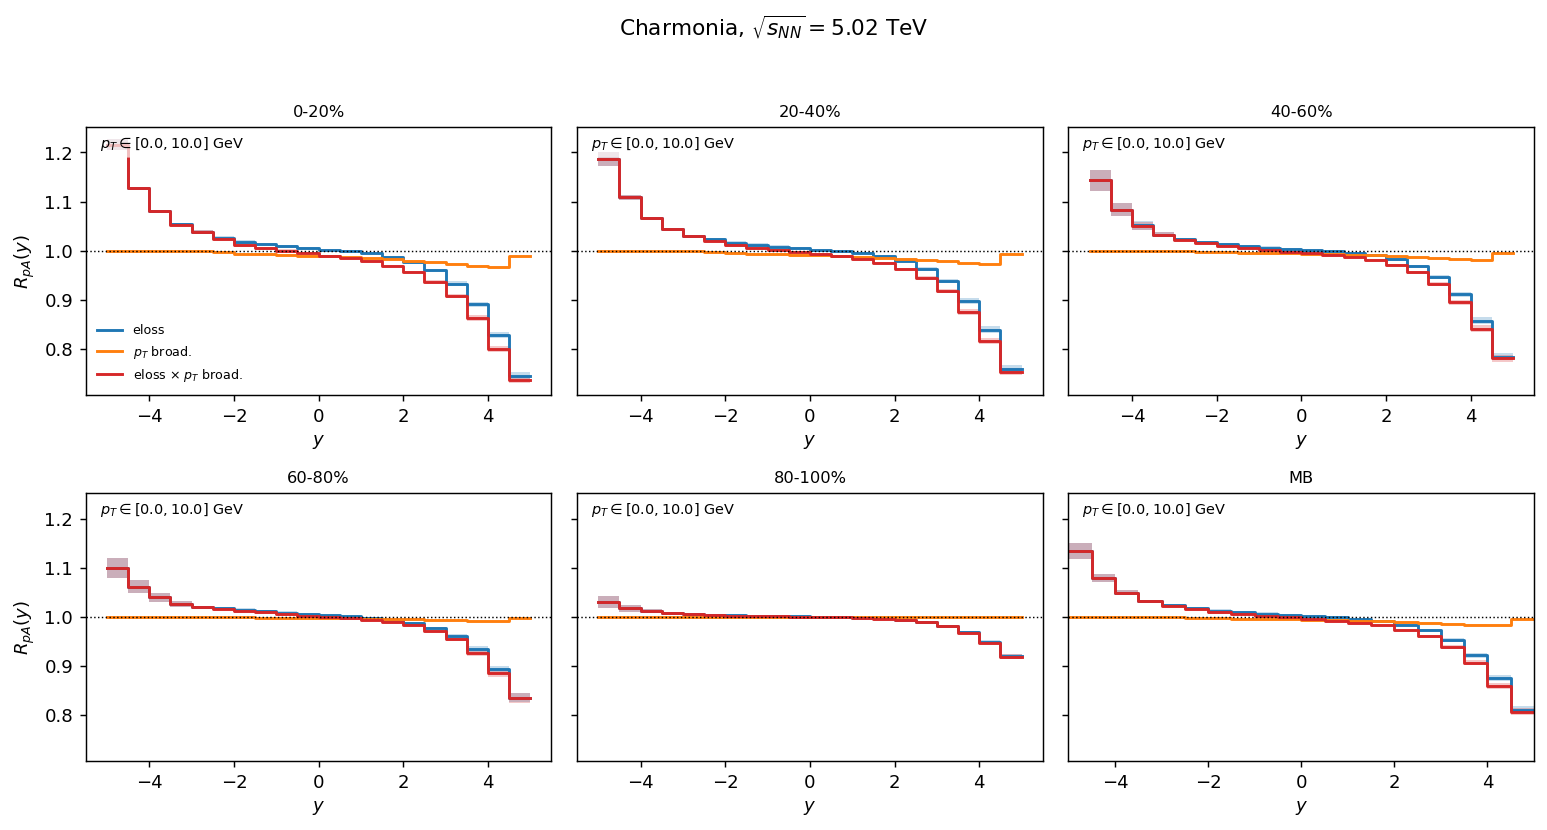

In [31]:
y_edges  = np.arange(-5.0, 5.0+0.5, 0.5)
pt_range = (0.0, 10.0)

fig, axes = plot_RpA_vs_y_components_per_centrality(
    P_charmonia, roots5, QP5_base,
    gl5, cent_bins,
    y_edges, pt_range,
    show_components=("loss", "broad", "total"),
    q0_pair=Q0_PAIR,
    p0_scale_pair=(0.9, 1.1),
    Ny_bin=12, Npt_bin=24,
    weight_kind="pp",
    weight_ref_y="local",
    include_MB=True,
    ncols=3,
    step=True,
    suptitle=r"Charmonia, $\sqrt{s_{NN}}=5.02$ TeV",
)

plt.savefig(
    "RpA_vs_y_components_by_centrality_charmonia_5TeV.pdf",
    dpi=300, bbox_inches="tight"
)

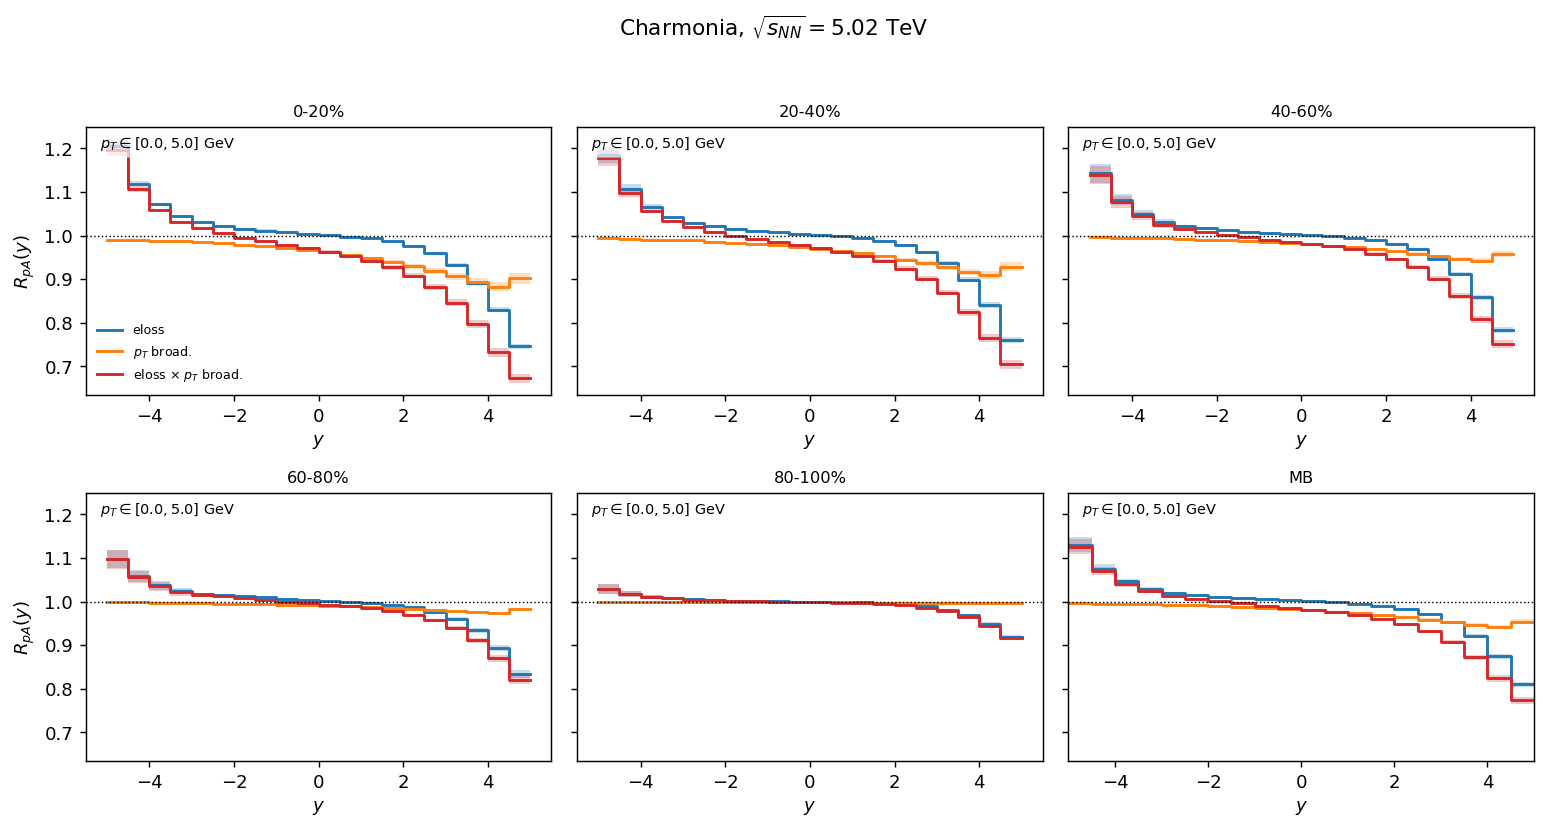

In [32]:
y_edges  = np.arange(-5.0, 5.0+0.5, 0.5)
pt_range = (0.0, 5.0)

fig, axes = plot_RpA_vs_y_components_per_centrality(
    P_charmonia, roots5, QP5_base,
    gl5, cent_bins,
    y_edges, pt_range,
    show_components=("loss", "broad", "total"),
    q0_pair=Q0_PAIR,
    p0_scale_pair=(0.9, 1.1),
    Ny_bin=12, Npt_bin=24,
    weight_kind="pp",
    weight_ref_y="local",
    include_MB=True,
    ncols=3,
    step=True,
    suptitle=r"Charmonia, $\sqrt{s_{NN}}=5.02$ TeV",
)

plt.savefig(
    "RpA_vs_y_components_by_centrality_charmonia_5TeV.pdf",
    dpi=300, bbox_inches="tight"
)

### $R^{eloss}_{pA}$, $R^{p_T \, broad}_{pA}$ & $R^{p_T \, eloss \times broad}_{pA}$ vs $p_T$ [Binned + BAND]

In [33]:
## p_T Plot band
def rpa_band_vs_pT_eloss(
    P, roots_GeV: float,
    qp_base,
    glauber, cent_bins,
    pT_edges, y_range,
    q0_pair=(0.05, 0.09),
    component="loss",
    Ny_bin: int = 12, Npt_bin: int = 24,
    weight_kind: str = "pp",
    weight_ref_y: float | str = "local",
):
    assert component in ("loss","total")

    q0_lo, q0_hi = q0_pair
    qp_lo = replace(qp_base, qhat0=float(q0_lo))
    qp_hi = replace(qp_base, qhat0=float(q0_hi))

    pT_cent_lo, R_lo, labels = rpa_binned_vs_pT(
        P, roots_GeV, qp_lo,
        glauber, cent_bins,
        pT_edges, y_range,
        components=(component,),
        Ny_bin=Ny_bin, Npt_bin=Npt_bin,
        weight_kind=weight_kind,
        weight_ref_y=weight_ref_y,
    )
    pT_cent_hi, R_hi, _ = rpa_binned_vs_pT(
        P, roots_GeV, qp_hi,
        glauber, cent_bins,
        pT_edges, y_range,
        components=(component,),
        Ny_bin=Ny_bin, Npt_bin=Npt_bin,
        weight_kind=weight_kind,
        weight_ref_y=weight_ref_y,
    )
    assert np.allclose(pT_cent_lo, pT_cent_hi)
    pT_cent = pT_cent_lo

    RL_c, RL_lo, RL_hi = {}, {}, {}
    for lab in R_lo[component].keys():   # cent bins + "MB"
        Rc, Rl, Rh = _two_point_band(R_lo[component][lab],
                                     R_hi[component][lab])
        RL_c[lab], RL_lo[lab], RL_hi[lab] = Rc, Rl, Rh

    return pT_cent, RL_c, RL_lo, RL_hi, labels

def rpa_band_vs_pT_broad(
    P, roots_GeV: float,
    qp_base,
    glauber, cent_bins,
    pT_edges, y_range,
    p0_scale_pair=(0.9, 1.1),
    component="broad",
    Ny_bin: int = 12, Npt_bin: int = 24,
    weight_kind: str = "pp",
    weight_ref_y: float | str = "local",
):
    assert component in ("broad","total")

    P_lo = particle_with_scaled_p0(P, p0_scale_pair[0])
    P_hi = particle_with_scaled_p0(P, p0_scale_pair[1])

    pT_cent_lo, R_lo, labels = rpa_binned_vs_pT(
        P_lo, roots_GeV, qp_base,
        glauber, cent_bins,
        pT_edges, y_range,
        components=(component,),
        Ny_bin=Ny_bin, Npt_bin=Npt_bin,
        weight_kind=weight_kind,
        weight_ref_y=weight_ref_y,
    )
    pT_cent_hi, R_hi, _ = rpa_binned_vs_pT(
        P_hi, roots_GeV, qp_base,
        glauber, cent_bins,
        pT_edges, y_range,
        components=(component,),
        Ny_bin=Ny_bin, Npt_bin=Npt_bin,
        weight_kind=weight_kind,
        weight_ref_y=weight_ref_y,
    )
    assert np.allclose(pT_cent_lo, pT_cent_hi)
    pT_cent = pT_cent_lo

    RB_c, RB_lo, RB_hi = {}, {}, {}
    for lab in R_lo[component].keys():   # cent bins + "MB"
        Rc, Rl, Rh = _two_point_band(R_lo[component][lab],
                                     R_hi[component][lab])
        RB_c[lab], RB_lo[lab], RB_hi[lab] = Rc, Rl, Rh

    return pT_cent, RB_c, RB_lo, RB_hi, labels


def rpa_band_vs_pT(
    P, roots_GeV: float,
    qp_base,
    glauber, cent_bins,
    pT_edges, y_range,
    components=("loss","broad","total"),
    q0_pair=(0.05, 0.09),
    p0_scale_pair=(0.9, 1.1),
    Ny_bin: int = 12, Npt_bin: int = 24,
    weight_kind: str = "pp",
    weight_ref_y: float | str = "local",
):
    """
    Full RpA band vs pT (y-integrated).

      • eloss band from q0_pair
      • broad band from p0_scale_pair
      • total band from factorised combination in quadrature.
    """
    # loss band
    pT_cent, RL_c, RL_lo, RL_hi, labels = rpa_band_vs_pT_eloss(
        P, roots_GeV, qp_base,
        glauber, cent_bins,
        pT_edges, y_range,
        q0_pair=q0_pair,
        component="loss",
        Ny_bin=Ny_bin, Npt_bin=Npt_bin,
        weight_kind=weight_kind,
        weight_ref_y=weight_ref_y,
    )

    # broad band
    pT_cent2, RB_c, RB_lo, RB_hi, labels_b = rpa_band_vs_pT_broad(
        P, roots_GeV, qp_base,
        glauber, cent_bins,
        pT_edges, y_range,
        p0_scale_pair=p0_scale_pair,
        component="broad",
        Ny_bin=Ny_bin, Npt_bin=Npt_bin,
        weight_kind=weight_kind,
        weight_ref_y=weight_ref_y,
    )
    assert np.allclose(pT_cent, pT_cent2)

    # total
    RT_c, RT_lo, RT_hi = combine_factorized_bands_1d(
        RL_c, RL_lo, RL_hi,
        RB_c, RB_lo, RB_hi,
    )

    bands: dict[str, tuple[dict,dict,dict]] = {}
    if "loss" in components:
        bands["loss"] = (RL_c, RL_lo, RL_hi)
    if "broad" in components:
        bands["broad"] = (RB_c, RB_lo, RB_hi)
    if "total" in components:
        bands["total"] = (RT_c, RT_lo, RT_hi)

    return pT_cent, bands, labels

In [34]:
def plot_RpA_vs_pT_band(
    pT_cent,
    Rc_dict, Rlow_dict, Rhigh_dict,
    tags_order,
    component_label=r"$R_{pA}(p_T)$",
    ax=None,
    step: bool = True,
    note: str | None = None,
):
    """
    RpA vs pT with centrality bands.

    Parameters
    ----------
    pT_cent        : 1D array of pT bin centres.
    Rc_dict        : dict[tag] -> central values.
    Rlow_dict      : dict[tag] -> lower band edge.
    Rhigh_dict     : dict[tag] -> upper band edge.
    step           : True → step-style per bin, False → smooth line.
    note           : optional text inside panel (e.g. y-range).
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(5.0, 3.5), dpi=130)
    else:
        fig = ax.figure

    for tag in tags_order:
        Rc  = np.asarray(Rc_dict[tag])
        Rlo = np.asarray(Rlow_dict[tag])
        Rhi = np.asarray(Rhigh_dict[tag])
        col = colors[tag]

        if step:
            x_edges, y_c  = _step_from_centers(pT_cent, Rc)
            _,       y_lo = _step_from_centers(pT_cent, Rlo)
            _,       y_hi = _step_from_centers(pT_cent, Rhi)

            ax.step(x_edges, y_c, where="post", lw=1.5, color=col, label=tag)
            ax.fill_between(x_edges, y_lo, y_hi,
                            step="post", alpha=0.25, color=col, linewidth=0.0)
        else:
            ax.plot(pT_cent, Rc, lw=1.5, color=col, label=tag)
            ax.fill_between(pT_cent, Rlo, Rhi,
                            alpha=0.25, color=col, linewidth=0.0)

    if "MB" in Rc_dict:
        Rc  = np.asarray(Rc_dict["MB"])
        Rlo = np.asarray(Rlow_dict["MB"])
        Rhi = np.asarray(Rhigh_dict["MB"])

        if step:
            x_edges, y_c  = _step_from_centers(pT_cent, Rc)
            _,       y_lo = _step_from_centers(pT_cent, Rlo)
            _,       y_hi = _step_from_centers(pT_cent, Rhi)

            ax.step(x_edges, y_c, where="post", lw=2.0, color="k", label="MB")
            ax.fill_between(x_edges, y_lo, y_hi,
                            step="post", alpha=0.3, color="gray", linewidth=0.0)
        else:
            ax.plot(pT_cent, Rc, lw=2.0, color="k", label="MB")
            ax.fill_between(pT_cent, Rlo, Rhi,
                            alpha=0.3, color="gray", linewidth=0.0)

    ax.axhline(1.0, color="k", ls=":", lw=0.8)
    ax.set_xlabel(r"$p_T$ [GeV]")
    ax.set_ylabel(component_label)
    ax.legend(frameon=False, fontsize=7, ncol=2)
    ax.grid(False)
    ax.set_xlim(0,15)

    if note is not None:
        ax.text(
            0.03, 0.97, note,
            transform=ax.transAxes,
            fontsize=8,
            va="top", ha="left",
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.7),
        )

    return fig, ax

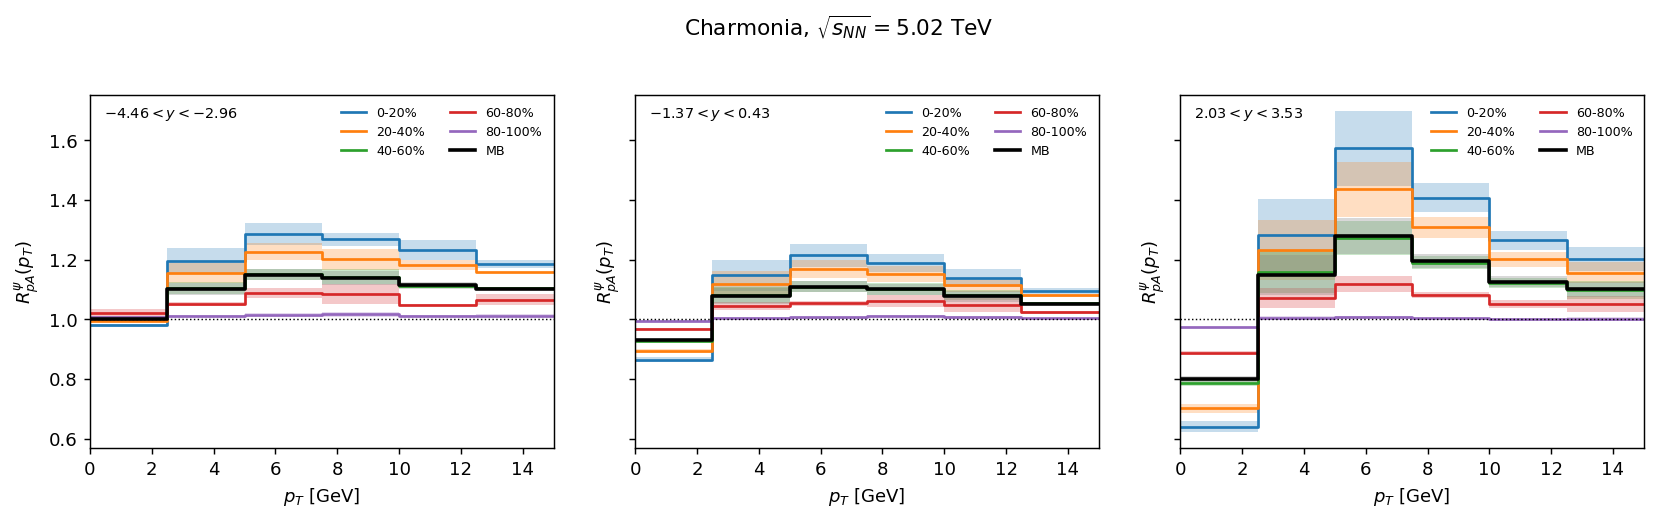

In [35]:
pT_edges = np.arange(0.0, 15.0+2.5, 2.5)

fig, axes = plt.subplots(1, 3, figsize=(13,4), dpi=130, sharey=True)
for ax, yr in zip(axes, RAPIDITY_WINDOWS):
    pT_cent, bands, labels5_pT = rpa_band_vs_pT(
        P_charmonia, roots5, QP5_base,
        gl5, cent_bins,
        pT_edges, yr,
        components=("total",),
        q0_pair=Q0_PAIR,
        p0_scale_pair=(0.9,1.1),
        Ny_bin=12, Npt_bin=24,
        weight_kind="pp",
        weight_ref_y="local",
    )
    RT_c, RT_lo, RT_hi = bands["total"]

    note = rf"${yr[0]:.2f}<y<{yr[1]:.2f}$"  # y-range inside panel

    plot_RpA_vs_pT_band(
        pT_cent, RT_c, RT_lo, RT_hi,
        tags_order,
        component_label=r"$R^{\psi}_{pA}(p_T)$",
        ax=ax,
        step=True,
        note=note,
    )
    ax.set_title("")  # title not strictly needed now; can leave blank

fig.suptitle(r"Charmonia, $\sqrt{s_{NN}}=5.02$ TeV", y=0.99)
fig.tight_layout(rect=[0,0,1,0.96])
plt.savefig(f'R_eloss_broad_pA_vs_pT_charmonia_5TeV.pdf', dpi=300, bbox_inches='tight')

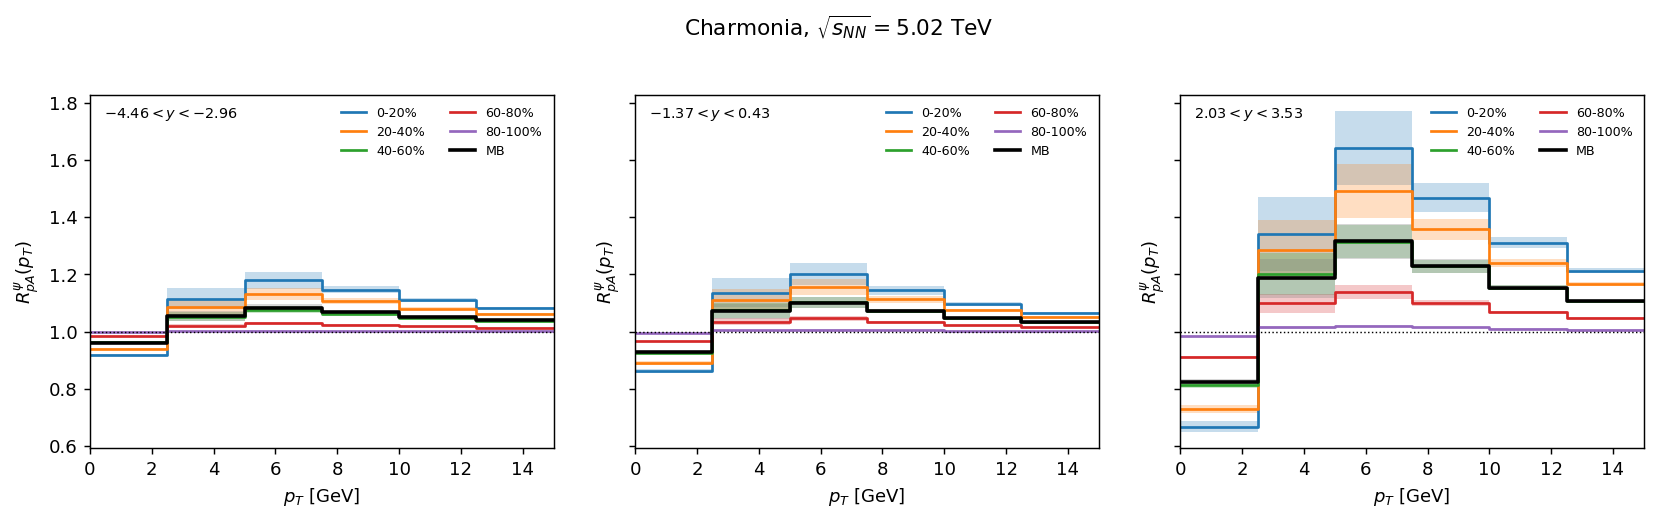

In [36]:
pT_edges = np.arange(0.0, 15.0+2.5, 2.5)

fig, axes = plt.subplots(1, 3, figsize=(13,4), dpi=130, sharey=True)
for ax, yr in zip(axes, RAPIDITY_WINDOWS):
    pT_cent, bands, labels5_pT = rpa_band_vs_pT(
        P_charmonia, roots5, QP5_base,
        gl5, cent_bins,
        pT_edges, yr,
        components=("broad",),
        q0_pair=Q0_PAIR,
        p0_scale_pair=(0.9,1.1),
        Ny_bin=12, Npt_bin=24,
        weight_kind="pp",
        weight_ref_y="local",
    )
    RT_c, RT_lo, RT_hi = bands["broad"]

    note = rf"${yr[0]:.2f}<y<{yr[1]:.2f}$"  # y-range inside panel

    plot_RpA_vs_pT_band(
        pT_cent, RT_c, RT_lo, RT_hi,
        tags_order,
        component_label=r"$R^{\psi}_{pA}(p_T)$",
        ax=ax,
        step=True,
        note=note,
    )
    ax.set_title("")  # title not strictly needed now; can leave blank

fig.suptitle(r"Charmonia, $\sqrt{s_{NN}}=5.02$ TeV", y=0.99)
fig.tight_layout(rect=[0,0,1,0.96])
plt.savefig(f'R_broad_pA_vs_pT_charmonia_5TeV.pdf', dpi=300, bbox_inches='tight')

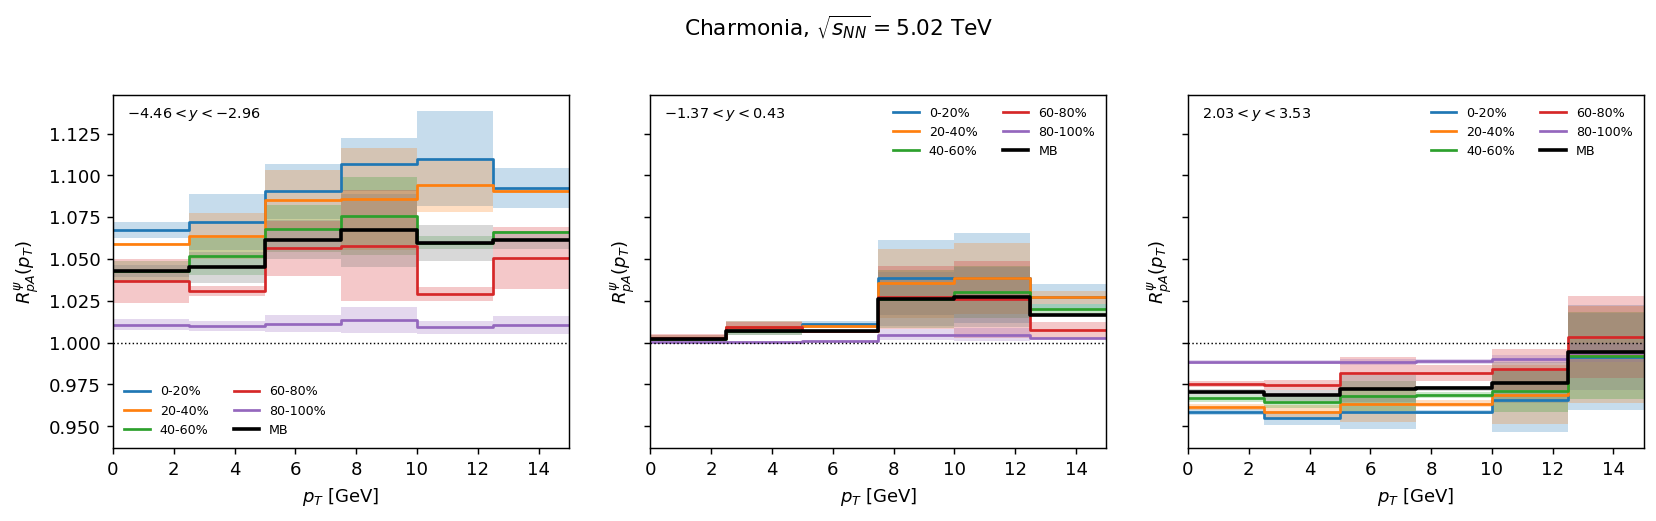

In [37]:
pT_edges = np.arange(0.0, 15.0+2.5, 2.5)

fig, axes = plt.subplots(1, 3, figsize=(13,4), dpi=130, sharey=True)
for ax, yr in zip(axes, RAPIDITY_WINDOWS):
    pT_cent, bands, labels5_pT = rpa_band_vs_pT(
        P_charmonia, roots5, QP5_base,
        gl5, cent_bins,
        pT_edges, yr,
        components=("loss",),
        q0_pair=Q0_PAIR,
        p0_scale_pair=(0.9,1.1),
        Ny_bin=12, Npt_bin=24,
        weight_kind="pp",
        weight_ref_y="local",
    )
    RT_c, RT_lo, RT_hi = bands["loss"]

    note = rf"${yr[0]:.2f}<y<{yr[1]:.2f}$"  # y-range inside panel

    plot_RpA_vs_pT_band(
        pT_cent, RT_c, RT_lo, RT_hi,
        tags_order,
        component_label=r"$R^{\psi}_{pA}(p_T)$",
        ax=ax,
        step=True,
        note=note,
    )
    ax.set_title("")  # title not strictly needed now; can leave blank

fig.suptitle(r"Charmonia, $\sqrt{s_{NN}}=5.02$ TeV", y=0.99)
fig.tight_layout(rect=[0,0,1,0.96])
plt.savefig(f'R_eloss_pA_vs_pT_charmonia_5TeV.pdf', dpi=300, bbox_inches='tight')

In [38]:
def plot_RpA_vs_pT_components_per_centrality(
    P, roots_GeV, qp_base,
    glauber, cent_bins,
    pT_edges, y_range,
    show_components=("loss", "broad", "total"),
    q0_pair=(0.05, 0.09),
    p0_scale_pair=(0.9, 1.1),
    Ny_bin: int = 12, Npt_bin: int = 24,
    weight_kind: str = "pp",
    weight_ref_y: float | str = "local",
    include_MB: bool = True,
    ncols: int = 3,
    step: bool = True,
    suptitle: str | None = None,
    ylabel: str = r"$R_{pA}(p_T)$",
):
    """
    Grid of subplots: one panel per centrality bin (+ optional MB),
    curves = components (loss, broad, total) vs pT.

    Layout:
        panels  = centrality bins (+ MB)
        curves  = components in show_components
        y-range fixed for this figure.
    """
    # Only request the components we actually need
    comp_list = tuple(sorted(set(show_components)))
    pT_cent, bands, labels = rpa_band_vs_pT(
        P, roots_GeV, qp_base,
        glauber, cent_bins,
        pT_edges, y_range,
        components=comp_list,
        q0_pair=q0_pair,
        p0_scale_pair=p0_scale_pair,
        Ny_bin=Ny_bin, Npt_bin=Npt_bin,
        weight_kind=weight_kind,
        weight_ref_y=weight_ref_y,
    )

    # Panels: centrality tags (+ MB)
    cent_tags = [f"{a}-{b}%" for (a, b) in cent_bins if (a, b) != (0, 100)]
    if include_MB:
        any_comp = next(iter(bands.values()))
        Rc_dict_any = any_comp[0]
        if "MB" in Rc_dict_any:
            cent_tags.append("MB")

    # Colours & labels per component (consistent with y-plots)
    comp_colors = {
        "loss":  "C0",
        "broad": "C1",
        "total": "C3",
    }
    comp_labels = {
        "loss":  r"eloss",
        "broad": r"$p_T$ broad.",
        "total": r"eloss $\times$ $p_T$ broad.",
    }

    # Note inside each panel: y-range + pT-range
    note = (
        rf"${y_range[0]:.2f}<y<{y_range[1]:.2f}$" + "\n"
        rf"$p_T\in[{pT_edges[0]:.1f},{pT_edges[-1]:.1f}]$ GeV"
    )

    # Figure / axes layout
    n_panels = len(cent_tags)
    ncols = min(ncols, n_panels)
    nrows = int(np.ceil(n_panels / ncols))

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(4.0 * ncols, 3.2 * nrows),
        dpi=130,
        sharey=True,
    )
    axes = np.atleast_1d(axes).ravel()

    for iax, (ax, tag) in enumerate(zip(axes, cent_tags)):
        for comp in show_components:
            Rc_dict, Rlo_dict, Rhi_dict = bands[comp]

            Rc  = np.asarray(Rc_dict[tag])
            Rlo = np.asarray(Rlo_dict[tag])
            Rhi = np.asarray(Rhi_dict[tag])

            col   = comp_colors.get(comp, "k")
            # Only first panel gets legend labels
            label = comp_labels.get(comp, comp) if iax == 0 else None

            if step:
                x_edges, y_c  = _step_from_centers(pT_cent, Rc)
                _,       y_lo = _step_from_centers(pT_cent, Rlo)
                _,       y_hi = _step_from_centers(pT_cent, Rhi)

                ax.step(x_edges, y_c, where="post",
                        lw=1.6, color=col, label=label)
                ax.fill_between(
                    x_edges, y_lo, y_hi,
                    step="post", alpha=0.25, color=col, linewidth=0.0
                )
            else:
                ax.plot(pT_cent, Rc, lw=1.6, color=col, label=label)
                ax.fill_between(
                    pT_cent, Rlo, Rhi,
                    alpha=0.25, color=col, linewidth=0.0
                )

        # R=1 reference line
        ax.axhline(1.0, color="k", ls=":", lw=0.8)

        # Panel title = centrality / MB
        if tag == "MB":
            ax.set_title("MB", fontsize=9)
        else:
            ax.set_title(tag, fontsize=9)

        # Left column gets y-label
        if iax % ncols == 0:
            ax.set_ylabel(ylabel)

        ax.set_xlabel(r"$p_T$ [GeV]")
        ax.set_xlim(pT_edges[0], pT_edges[-1])
        ax.grid(False)

        # Note inside panel
        ax.text(
            0.03, 0.97, note,
            transform=ax.transAxes,
            fontsize=8,
            va="top", ha="left",
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.7),
        )

        # Only first axis gets legend
        if iax == 0:
            ax.legend(frameon=False, fontsize=7, loc="lower left")

    # Remove any unused axes
    for j in range(n_panels, len(axes)):
        fig.delaxes(axes[j])

    if suptitle is not None:
        fig.suptitle(suptitle, y=0.99)

    fig.tight_layout(rect=[0, 0, 1, 0.96] if suptitle else None)
    return fig, axes

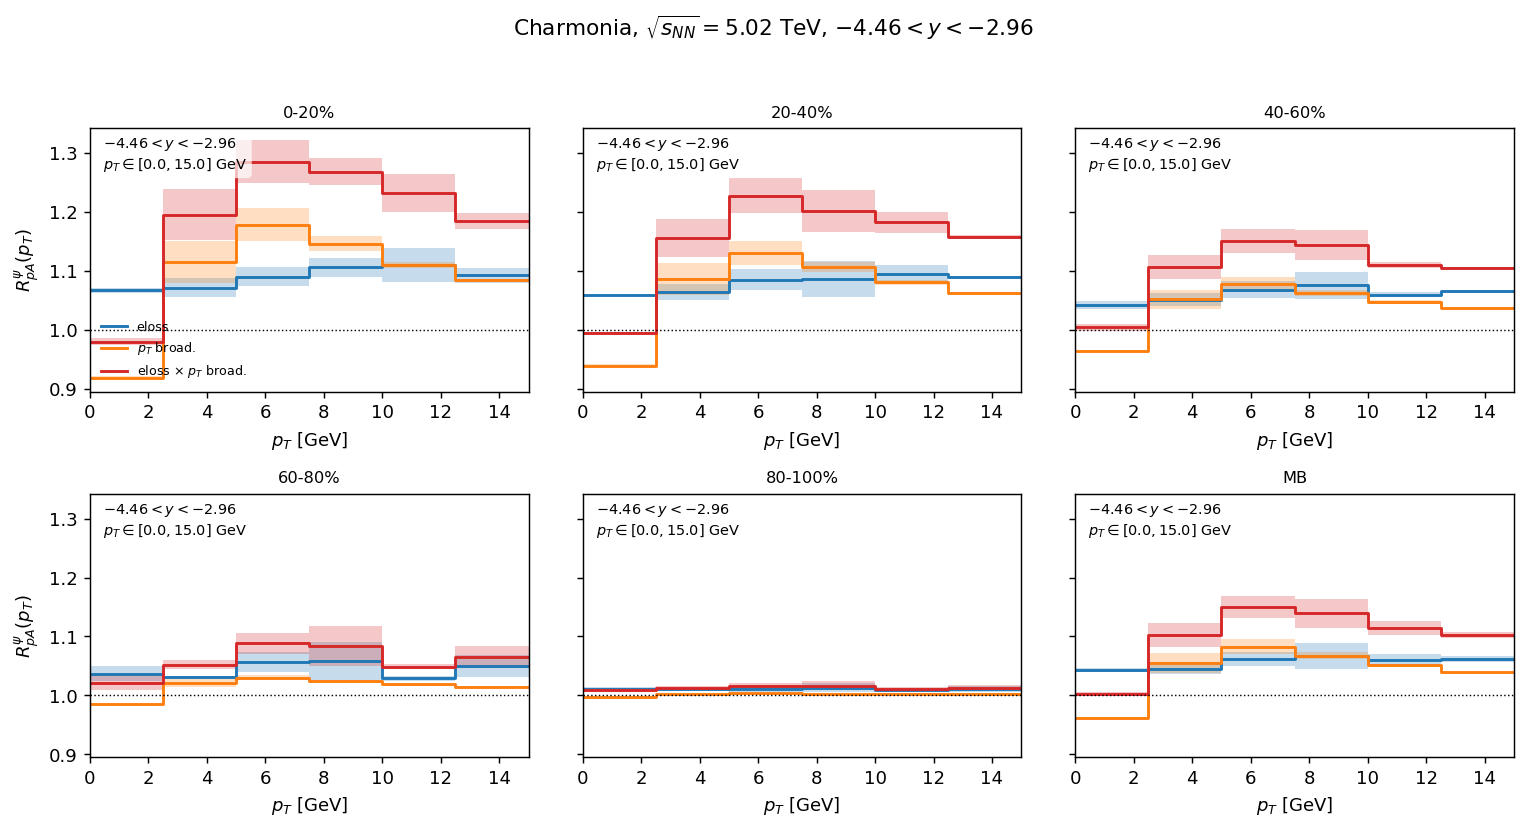

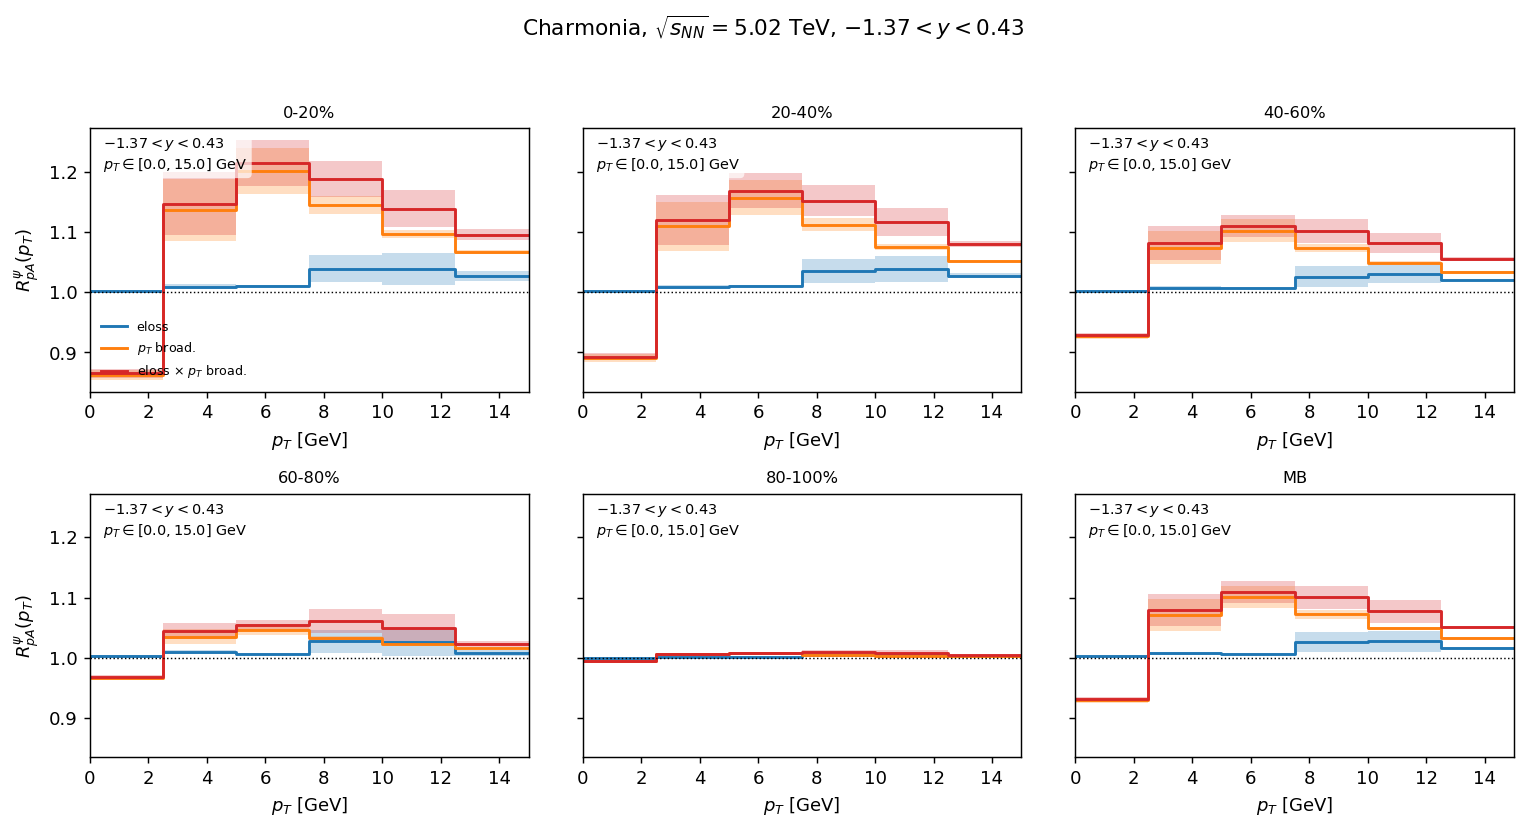

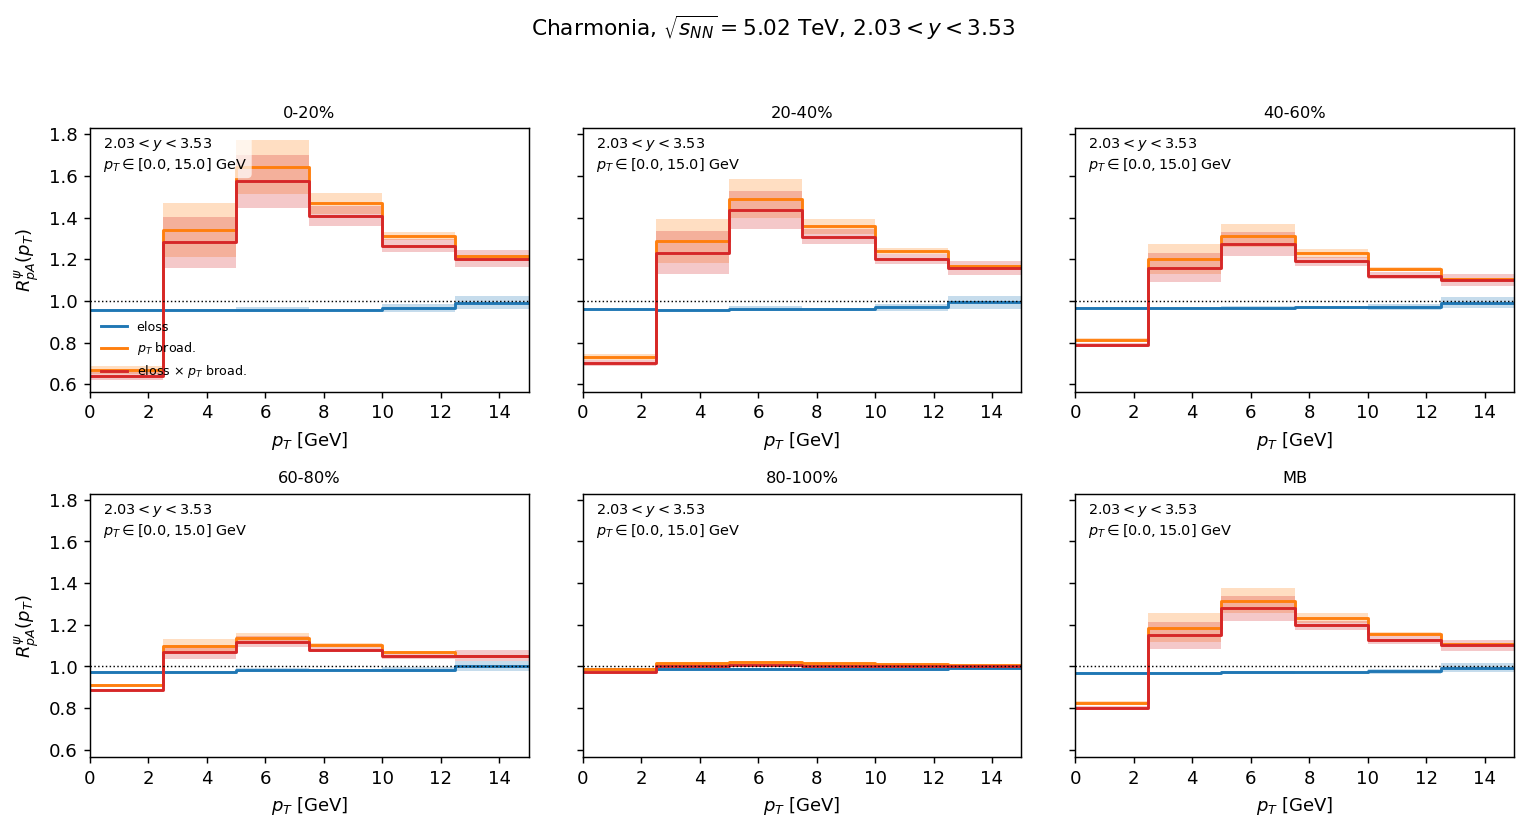

In [39]:
pT_edges = np.arange(0.0, 15.0+2.5, 2.5)

for yr in RAPIDITY_WINDOWS:
    fig, axes = plot_RpA_vs_pT_components_per_centrality(
        P_charmonia, roots5, QP5_base,
        gl5, cent_bins,
        pT_edges, yr,
        show_components=("loss", "broad", "total"),  # or any subset
        q0_pair=Q0_PAIR,
        p0_scale_pair=(0.9, 1.1),
        Ny_bin=12, Npt_bin=24,
        weight_kind="pp",
        weight_ref_y="local",
        include_MB=True,
        ncols=3,
        step=True,
        suptitle=(
            r"Charmonia, $\sqrt{s_{NN}}=5.02$ TeV, "
            + rf"${yr[0]:.2f}<y<{yr[1]:.2f}$"
        ),
        ylabel=r"$R^{\psi}_{pA}(p_T)$",
    )

    fname = (
        f"R_components_pA_vs_pT_charmonia_5TeV_"
        f"y({yr[0]:+.2f},{yr[1]:+.2f}).pdf"
    )
    plt.savefig(fname, dpi=300, bbox_inches="tight")

### $R^{eloss}_{pA}$, $R^{p_T \, broad}_{pA}$ & $R^{p_T \, eloss \times broad}_{pA}$ vs Centrality

In [40]:
# ================================
# RpA vs centrality
# ================================

def centrality_step_arrays(cent_bins, vals):
    """
    Build step-plot arrays from centrality bins [(0,20), ...] and
    values array of length len(cent_bins).

    Returns
    -------
    x_edges : array, shape (Nbins+1,)
        Edges [0,20,40,60,80,100] for 5 bins.
    y_step : array, shape (Nbins+1,)
        Values repeated so that plt.step(..., where="post")
        produces flat segments on each bin.
    """
    vals = np.asarray(vals, float)
    assert len(vals) == len(cent_bins)

    edges = [cent_bins[0][0]] + [b for (_, b) in cent_bins]
    x_edges = np.array(edges, float)          # e.g. [0,20,40,60,80,100]
    y_step  = np.concatenate([vals, vals[-1:]])
    return x_edges, y_step

## binning in each centrality (by centrality weight)
def rpa_vs_centrality(
    P, roots_GeV: float, qp_base,
    glauber, cent_bins,
    y_range, pt_range,
    component: str = "total",
    Ny_bin: int = 16, Npt_bin: int = 32,
    table_for_pp=None,
    weight_kind: str = "pp",
    weight_ref_y: float | str = "local",
):
    """
    Centrality dependence of RpA:

      <R>_bin(a–b%) = ⟨R(y,pT)⟩_{y_range × pt_range} in that bin.

    L_eff(a–b%) from OpticalGlauber; weights are either flat or σ_pp(y_w,pT)·pT
    (y_w = y or y_w = y_ref depending on weight_ref_y).

    Returns
    -------
      labels : ["0-20%", ..., "80-100%"]
      R_vals : array(Nbins) — RpA in each bin
      R_MB   : float — min-bias RpA using optical bin weights
    """
    assert component in ("loss","broad","total")
    labels = [f"{int(a)}-{int(b)}%" for (a,b) in cent_bins]

    L_by = glauber.leff_bins_pA(cent_bins, method="optical")
    Leff_dict = {lab: float(L_by[lab]) for lab in labels}

    R_vals = []

    for lab, (a,b) in zip(labels, cent_bins):
        L   = Leff_dict[lab]
        qpL = replace(qp_base, LA_fm=L)

        def R_loss(y, pT, qpL=qpL):
            return R_pA_eloss(P, roots_GeV, qpL, y, pT, Ny=None)

        def R_broad(y, pT, qpL=qpL):
            return R_pA_broad(P, roots_GeV, qpL, y, pT, Nphi=64)

        if component == "loss":
            R_func = R_loss
        elif component == "broad":
            R_func = R_broad
        else:
            def R_func(y, pT, qpL=qpL):
                return R_loss(y, pT, qpL=qpL) * R_broad(y, pT, qpL=qpL)

        R_bin = R_binned_2D(
            R_func, P, roots_GeV,
            y_range, pt_range,
            Ny_bin=Ny_bin, Npt_bin=Npt_bin,
            weight_kind=weight_kind,
            table_for_pp=table_for_pp,
            weight_ref_y=weight_ref_y,
        )
        R_vals.append(R_bin)

    R_vals = np.array(R_vals)

    # min-bias over centralities using optical weights
    w_bins = np.array(
        [QF._optical_bin_weight_pA(glauber, a, b) for (a,b) in cent_bins],
        float
    )
    w_bins = w_bins / max(w_bins.sum(), 1e-30)
    R_MB = float(np.average(R_vals, weights=w_bins))

    return labels, R_vals, R_MB

## Band
def rpa_band_vs_centrality(
    P, roots_GeV: float, qp_base,
    glauber, cent_bins,
    y_range, pt_range,
    q0_pair=(0.05, 0.09),
    p0_scale_pair=(0.9, 1.1),
    Ny_bin: int = 16, Npt_bin: int = 32,
    weight_kind: str = "pp",
    weight_ref_y: float | str = "local",
):
    """
    Error bands vs centrality:

      • q0_pair       → energy-loss band
      • p0_scale_pair → pp(p0) scale band for Cronin (broadening)
      • total band    → quadrature combination of eloss + broad.

    We do NOT treat the (0,100) "MB bin" as a separate optical bin here;
    MB is computed from optical weights over the genuine bins.
    """
    # Drop any explicit 0-100 bin from the core averaging:
    core_bins = [b for b in cent_bins if not (b[0] == 0 and b[1] == 100)]
    labels    = [f"{int(a)}-{int(b)}%" for (a,b) in core_bins]

    # ---------- loss band (q0 scan) ----------
    q0_lo, q0_hi = q0_pair
    RL_lo, RL_hi, RL_c = {}, {}, {}

    for q0, store in [(q0_lo, RL_lo), (q0_hi, RL_hi)]:
        qp_q = replace(qp_base, qhat0=float(q0))
        _, Rvals_q, _ = rpa_vs_centrality(
            P, roots_GeV, qp_q, glauber, core_bins,
            y_range, pt_range,
            component="loss",
            Ny_bin=Ny_bin, Npt_bin=Npt_bin,
            weight_kind=weight_kind,
            weight_ref_y=weight_ref_y,
        )
        for lab, val in zip(labels, Rvals_q):
            store[lab] = val

    for lab in labels:
        Rc = 0.5*(RL_lo[lab] + RL_hi[lab])
        dR = 0.5*abs(RL_hi[lab] - RL_lo[lab])
        RL_c[lab]  = Rc
        RL_lo[lab] = Rc - dR
        RL_hi[lab] = Rc + dR

    # ---------- broad band (p0 scan) ----------
    RB_lo, RB_hi, RB_c = {}, {}, {}

    for p0_scale, store in [(p0_scale_pair[0], RB_lo),
                            (p0_scale_pair[1], RB_hi)]:
        P_scaled = particle_with_scaled_p0(P, p0_scale)
        _, Rvals_q, _ = rpa_vs_centrality(
            P_scaled, roots_GeV, qp_base, glauber, core_bins,
            y_range, pt_range,
            component="broad",
            Ny_bin=Ny_bin, Npt_bin=Npt_bin,
            weight_kind=weight_kind,
            weight_ref_y=weight_ref_y,
        )
        for lab, val in zip(labels, Rvals_q):
            store[lab] = val

    for lab in labels:
        Rc = 0.5*(RB_lo[lab] + RB_hi[lab])
        dR = 0.5*abs(RB_hi[lab] - RB_lo[lab])
        RB_c[lab]  = Rc
        RB_lo[lab] = Rc - dR
        RB_hi[lab] = Rc + dR

    # ---------- combine loss + broad in quadrature ----------
    RT_c, RT_lo, RT_hi = {}, {}, {}
    for lab in labels:
        Lc, Llo, Lhi = RL_c[lab], RL_lo[lab], RL_hi[lab]
        Bc, Blo, Bhi = RB_c[lab], RB_lo[lab], RB_hi[lab]

        dL = 0.5*abs(Lhi - Llo)
        dB = 0.5*abs(Bhi - Blo)

        Lc_safe = Lc if abs(Lc) > 1e-10 else 1.0
        Bc_safe = Bc if abs(Bc) > 1e-10 else 1.0

        Rc   = Lc * Bc
        rel2 = (dL/Lc_safe)**2 + (dB/Bc_safe)**2
        dR   = Rc * math.sqrt(rel2)

        RT_c[lab]  = Rc
        RT_lo[lab] = Rc - dR
        RT_hi[lab] = Rc + dR

    # ---------- MB values (optical weights over core bins only) ----------
    w_bins = np.array(
        [QF._optical_bin_weight_pA(glauber, a, b) for (a,b) in core_bins],
        float
    )
    w_bins = w_bins / max(w_bins.sum(), 1e-30)

    def _mb_from_dict(Dc, Dlo, Dhi):
        arr_c  = np.array([Dc[lab]  for lab in labels])
        arr_lo = np.array([Dlo[lab] for lab in labels])
        arr_hi = np.array([Dhi[lab] for lab in labels])

        Rc  = float(np.average(arr_c,  weights=w_bins))
        Rlo = float(np.average(arr_lo, weights=w_bins))
        Rhi = float(np.average(arr_hi, weights=w_bins))
        return Rc, Rlo, Rhi

    RMB_loss  = _mb_from_dict(RL_c, RL_lo, RL_hi)
    RMB_broad = _mb_from_dict(RB_c, RB_lo, RB_hi)

    # total MB via factorised combination
    RcL_MB, RloL_MB, RhiL_MB = RMB_loss
    RcB_MB, RloB_MB, RhiB_MB = RMB_broad
    dL_MB = 0.5*abs(RhiL_MB - RloL_MB)
    dB_MB = 0.5*abs(RhiB_MB - RloB_MB)
    Rc_MB = RcL_MB * RcB_MB
    rel2_MB = (dL_MB/max(abs(RcL_MB),1e-12))**2 + (dB_MB/max(abs(RcB_MB),1e-12))**2
    dR_MB = Rc_MB * math.sqrt(rel2_MB)
    RMB_tot = (Rc_MB, Rc_MB - dR_MB, Rc_MB + dR_MB)

    return (labels,
            RL_c, RL_lo, RL_hi,
            RB_c, RB_lo, RB_hi,
            RT_c, RT_lo, RT_hi,
            RMB_loss, RMB_broad, RMB_tot)

In [41]:
def plot_RpA_vs_centrality_components_band(
    cent_bins, labels,
    RL_c=None, RL_lo=None, RL_hi=None, RMB_loss=None,
    RB_c=None, RB_lo=None, RB_hi=None, RMB_broad=None,
    RT_c=None, RT_lo=None, RT_hi=None, RMB_tot=None,
    show=("total",),                  # e.g. ("loss","broad","total")
    ax=None,
    ylabel=r"$R_{pA}(\mathrm{cent})$",
    note: str | None = None,
    system_label: str | None = None,  # e.g. r"$5.02$ TeV p+Pb"
):
    """
    Step-style RpA vs centrality, with optional bands for
    loss, broad, and total components, plus MB horizontal band.

    Parameters
    ----------
    cent_bins : list of (a,b) centrality edges.
    labels    : list of matching strings "a-b%".
    RL_*      : dict[lab] -> scalar, loss band (central, low, high).
    RB_*      : dict[lab] -> scalar, broad band.
    RT_*      : dict[lab] -> scalar, total band.
    RMB_*     : (Rc_MB, Rlo_MB, Rhi_MB) tuples per component.
    show      : tuple of components to show ("loss","broad","total").
    system_label : string appended to legend label for "total".
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(4.0, 3.5), dpi=130)
    else:
        fig = ax.figure

    # colours & labels per component
    comp_color = {
        "loss":  "C1",
        "broad": "C2",
        "total": "C0",
    }
    comp_label = {
        "loss":  r"loss",
        "broad": r"broad",
        "total": r"total",
    }
    if system_label is not None:
        comp_label["total"] = system_label  # e.g. "5.02 TeV p+Pb"

    # helper to step-plot one component
    def _plot_comp(comp, Cc, Clo, Chi):
        vals_c  = np.array([Cc[lab]  for lab in labels])
        vals_lo = np.array([Clo[lab] for lab in labels])
        vals_hi = np.array([Chi[lab] for lab in labels])

        x_edges, y_c  = centrality_step_arrays(cent_bins, vals_c)
        _,       y_lo = centrality_step_arrays(cent_bins, vals_lo)
        _,       y_hi = centrality_step_arrays(cent_bins, vals_hi)

        col = comp_color[comp]
        lab = comp_label[comp]

        ax.step(x_edges, y_c, where="post", lw=2.0, color=col, label=lab)
        ax.fill_between(x_edges, y_lo, y_hi,
                        step="post", alpha=0.25, color=col, linewidth=0.0)

    # loss
    if "loss" in show and RL_c is not None:
        _plot_comp("loss", RL_c, RL_lo, RL_hi)

        if RMB_loss is not None:
            Rc_MB, Rlo_MB, Rhi_MB = RMB_loss
            x_band = np.array([cent_bins[0][0], cent_bins[-1][1]], float)
            ax.hlines(Rc_MB, x_band[0], x_band[1],
                      colors=comp_color["loss"], linestyles="--",
                      linewidth=1.2, label=r"MB loss")
            ax.fill_between(
                x_band,
                [Rlo_MB, Rlo_MB],
                [Rhi_MB, Rhi_MB],
                color=comp_color["loss"], alpha=0.12, linewidth=0.0,
            )

    # broad
    if "broad" in show and RB_c is not None:
        _plot_comp("broad", RB_c, RB_lo, RB_hi)

        if RMB_broad is not None:
            Rc_MB, Rlo_MB, Rhi_MB = RMB_broad
            x_band = np.array([cent_bins[0][0], cent_bins[-1][1]], float)
            ax.hlines(Rc_MB, x_band[0], x_band[1],
                      colors=comp_color["broad"], linestyles="--",
                      linewidth=1.2, label=r"MB broad")
            ax.fill_between(
                x_band,
                [Rlo_MB, Rlo_MB],
                [Rhi_MB, Rhi_MB],
                color=comp_color["broad"], alpha=0.12, linewidth=0.0,
            )

    # total (this is usually the main one, with darker MB)
    if "total" in show and RT_c is not None:
        _plot_comp("total", RT_c, RT_lo, RT_hi)

        if RMB_tot is not None:
            Rc_MB, Rlo_MB, Rhi_MB = RMB_tot
            x_band = np.array([cent_bins[0][0], cent_bins[-1][1]], float)
            ax.hlines(Rc_MB, x_band[0], x_band[1],
                      colors="k", linestyles="--",
                      linewidth=1.6, label=r"MB total")
            ax.fill_between(
                x_band,
                [Rlo_MB, Rlo_MB],
                [Rhi_MB, Rhi_MB],
                color="gray", alpha=0.30, linewidth=0.0,
            )

    ax.axhline(1.0, color="k", ls=":", lw=0.8)
    ax.set_xlabel("centrality [%]")
    ax.set_ylabel(ylabel)
    ax.set_xlim(cent_bins[0][0], cent_bins[-1][1])
    ax.grid(False)
    ax.legend(frameon=False, fontsize=7, loc="lower left")

    if note is not None:
        ax.text(
            0.03, 0.97, note,
            transform=ax.transAxes,
            fontsize=8,
            va="top", ha="left",
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.7),
        )

    return fig, ax

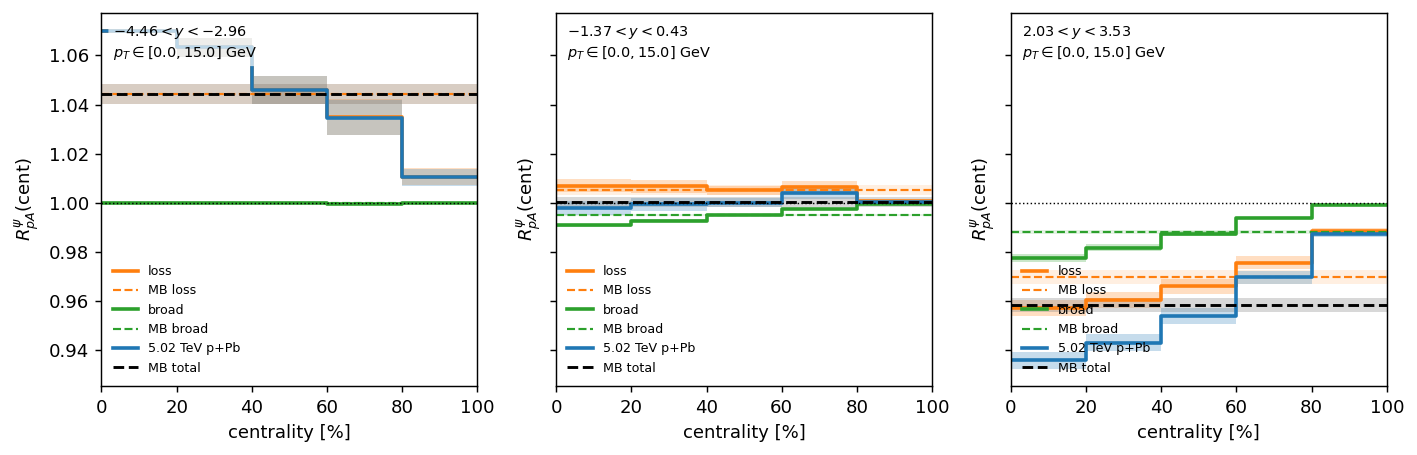

In [42]:
pt_range       = (0.0, 15.0)
core_cent_bins = [(0,20),(20,40),(40,60),(60,80),(80,100)]

fig, axes = plt.subplots(1, 3, figsize=(11,3.6), dpi=130, sharey=True)

for ax, yr in zip(axes, RAPIDITY_WINDOWS):
    (labels,
     RL_c, RL_lo, RL_hi,
     RB_c, RB_lo, RB_hi,
     RT_c, RT_lo, RT_hi,
     RMB_loss, RMB_broad, RMB_tot) = rpa_band_vs_centrality(
         P_charmonia, roots5, QP5_base,
         gl5, core_cent_bins,
         yr, pt_range,
         q0_pair=Q0_PAIR,
         p0_scale_pair=(0.9,1.1),
         Ny_bin=16, Npt_bin=32,
         weight_kind="pp",
    )

    note = (
        rf"${yr[0]:.2f}<y<{yr[1]:.2f}$" + "\n"
        rf"$p_T\in[{pt_range[0]:.1f},{pt_range[1]:.1f}]$ GeV"
    )

    plot_RpA_vs_centrality_components_band(
        core_cent_bins, labels,
        RL_c=RL_c, RL_lo=RL_lo, RL_hi=RL_hi, RMB_loss=RMB_loss,
        RB_c=RB_c, RB_lo=RB_lo, RB_hi=RB_hi, RMB_broad=RMB_broad,
        RT_c=RT_c, RT_lo=RT_lo, RT_hi=RT_hi, RMB_tot=RMB_tot,
        show=("loss","broad","total"),   # choose what you want
        ax=ax,
        ylabel=r"$R^{\psi}_{pA}(\mathrm{cent})$",
        note=note,
        system_label=r"5.02 TeV p+Pb",
    )

fig.tight_layout()
plt.savefig(f'R_eloss_broad_pA_vs_cent_charmonia_5TeV_pT({pt_range[0]:.1f},{pt_range[1]:.1f}).pdf', dpi=300, bbox_inches='tight')

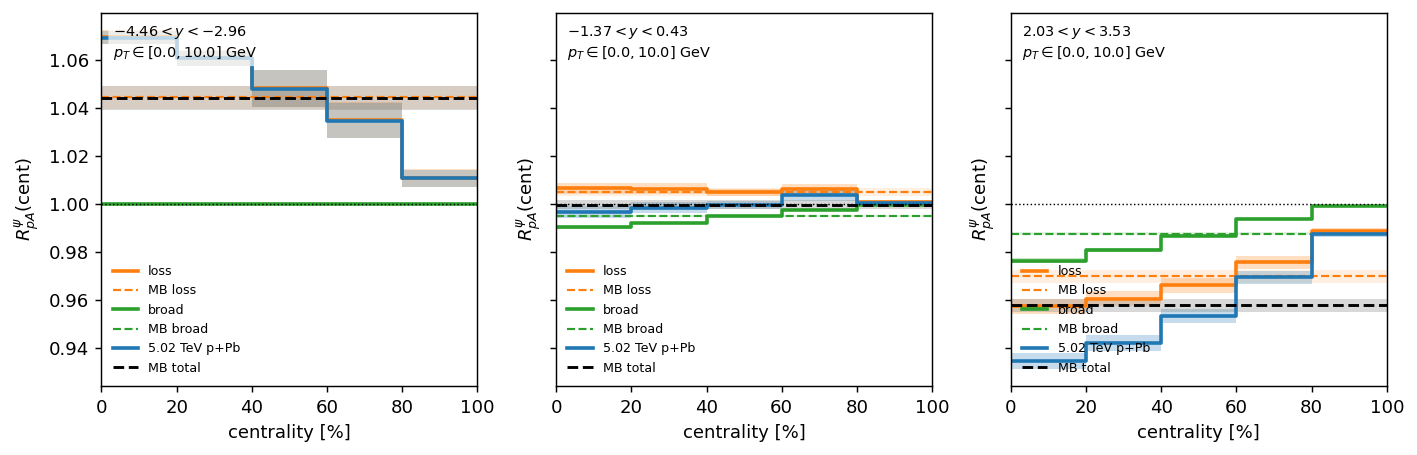

In [43]:
pt_range       = (0.0, 10.0)
core_cent_bins = [(0,20),(20,40),(40,60),(60,80),(80,100)]

fig, axes = plt.subplots(1, 3, figsize=(11,3.6), dpi=130, sharey=True)

for ax, yr in zip(axes, RAPIDITY_WINDOWS):
    (labels,
     RL_c, RL_lo, RL_hi,
     RB_c, RB_lo, RB_hi,
     RT_c, RT_lo, RT_hi,
     RMB_loss, RMB_broad, RMB_tot) = rpa_band_vs_centrality(
         P_charmonia, roots5, QP5_base,
         gl5, core_cent_bins,
         yr, pt_range,
         q0_pair=Q0_PAIR,
         p0_scale_pair=(0.9,1.1),
         Ny_bin=16, Npt_bin=32,
         weight_kind="pp",
    )

    note = (
        rf"${yr[0]:.2f}<y<{yr[1]:.2f}$" + "\n"
        rf"$p_T\in[{pt_range[0]:.1f},{pt_range[1]:.1f}]$ GeV"
    )

    plot_RpA_vs_centrality_components_band(
        core_cent_bins, labels,
        RL_c=RL_c, RL_lo=RL_lo, RL_hi=RL_hi, RMB_loss=RMB_loss,
        RB_c=RB_c, RB_lo=RB_lo, RB_hi=RB_hi, RMB_broad=RMB_broad,
        RT_c=RT_c, RT_lo=RT_lo, RT_hi=RT_hi, RMB_tot=RMB_tot,
        show=("loss","broad","total"),   # choose what you want
        ax=ax,
        ylabel=r"$R^{\psi}_{pA}(\mathrm{cent})$",
        note=note,
        system_label=r"5.02 TeV p+Pb",
    )

fig.tight_layout()
plt.savefig(f'R_eloss_broad_pA_vs_cent_charmonia_5TeV_pT({pt_range[0]:.1f},{pt_range[1]:.1f}).pdf', dpi=300, bbox_inches='tight')

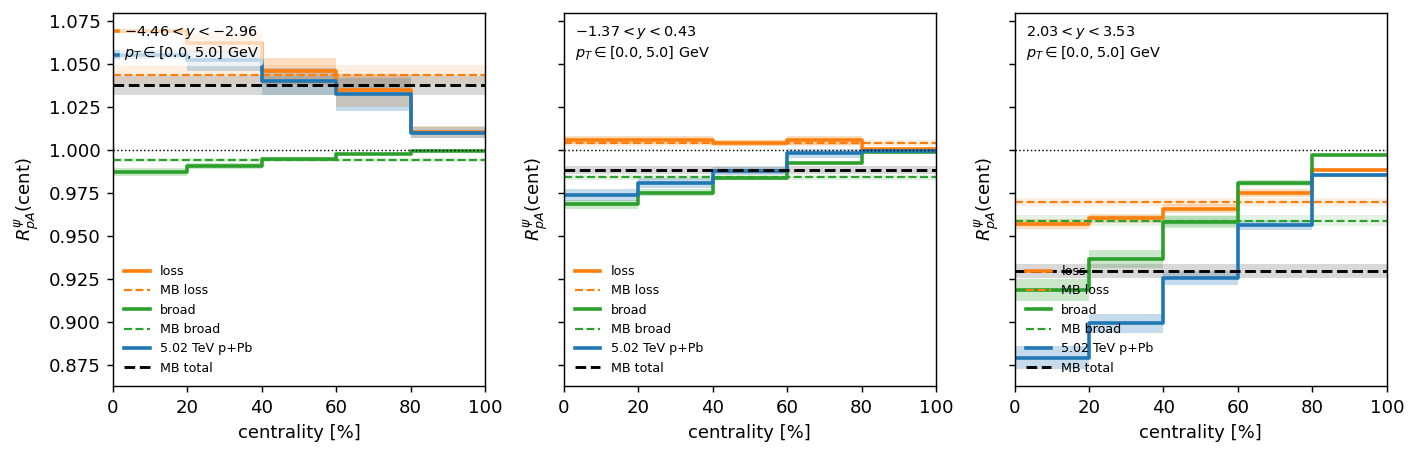

In [44]:
pt_range       = (0.0, 5.0)
core_cent_bins = [(0,20),(20,40),(40,60),(60,80),(80,100)]

fig, axes = plt.subplots(1, 3, figsize=(11,3.6), dpi=130, sharey=True)

for ax, yr in zip(axes, RAPIDITY_WINDOWS):
    (labels,
     RL_c, RL_lo, RL_hi,
     RB_c, RB_lo, RB_hi,
     RT_c, RT_lo, RT_hi,
     RMB_loss, RMB_broad, RMB_tot) = rpa_band_vs_centrality(
         P_charmonia, roots5, QP5_base,
         gl5, core_cent_bins,
         yr, pt_range,
         q0_pair=Q0_PAIR,
         p0_scale_pair=(0.9,1.1),
         Ny_bin=16, Npt_bin=32,
         weight_kind="pp",
    )

    note = (
        rf"${yr[0]:.2f}<y<{yr[1]:.2f}$" + "\n"
        rf"$p_T\in[{pt_range[0]:.1f},{pt_range[1]:.1f}]$ GeV"
    )

    plot_RpA_vs_centrality_components_band(
        core_cent_bins, labels,
        RL_c=RL_c, RL_lo=RL_lo, RL_hi=RL_hi, RMB_loss=RMB_loss,
        RB_c=RB_c, RB_lo=RB_lo, RB_hi=RB_hi, RMB_broad=RMB_broad,
        RT_c=RT_c, RT_lo=RT_lo, RT_hi=RT_hi, RMB_tot=RMB_tot,
        show=("loss","broad","total"),   # choose what you want
        ax=ax,
        ylabel=r"$R^{\psi}_{pA}(\mathrm{cent})$",
        note=note,
        system_label=r"5.02 TeV p+Pb",
    )

fig.tight_layout()
plt.savefig(f'R_eloss_broad_pA_vs_cent_charmonia_5TeV_pT({pt_range[0]:.1f},{pt_range[1]:.1f}).pdf', dpi=300, bbox_inches='tight')

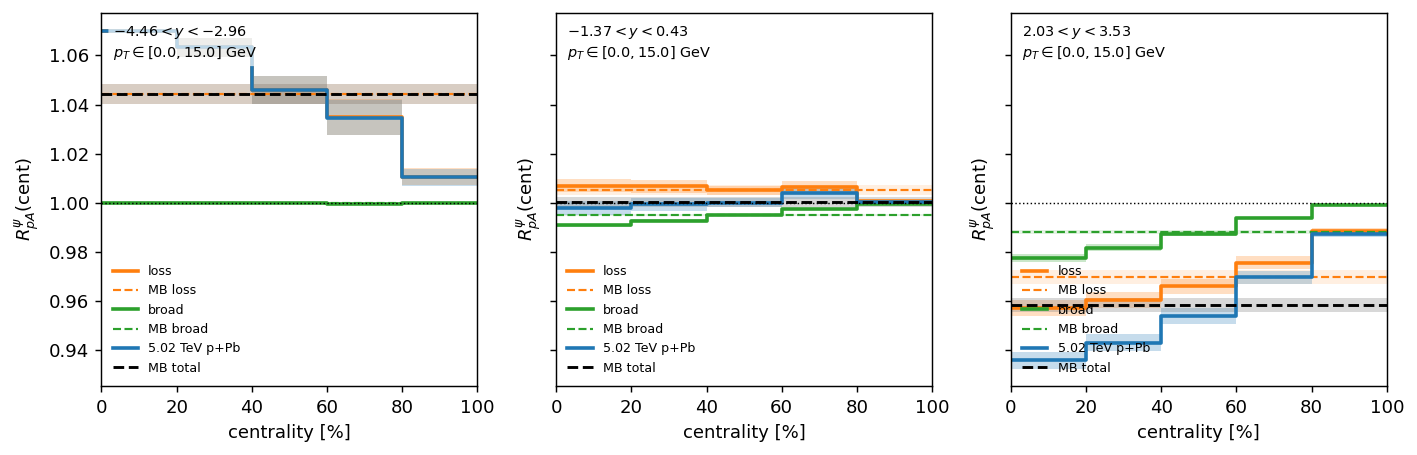

In [45]:
pt_range       = (0.0, 15.0)
core_cent_bins = [(0,20),(20,40),(40,60),(60,80),(80,100)]

fig, axes = plt.subplots(1, 3, figsize=(11,3.6), dpi=130, sharey=True)

for ax, yr in zip(axes, RAPIDITY_WINDOWS):
    (labels,
     RL_c, RL_lo, RL_hi,
     RB_c, RB_lo, RB_hi,
     RT_c, RT_lo, RT_hi,
     RMB_loss, RMB_broad, RMB_tot) = rpa_band_vs_centrality(
         P_charmonia, roots5, QP5_base,
         gl5, core_cent_bins,
         yr, pt_range,
         q0_pair=Q0_PAIR,
         p0_scale_pair=(0.9,1.1),
         Ny_bin=16, Npt_bin=32,
         weight_kind="pp",
    )

    note = (
        rf"${yr[0]:.2f}<y<{yr[1]:.2f}$" + "\n"
        rf"$p_T\in[{pt_range[0]:.1f},{pt_range[1]:.1f}]$ GeV"
    )

    plot_RpA_vs_centrality_components_band(
        core_cent_bins, labels,
        RL_c=RL_c, RL_lo=RL_lo, RL_hi=RL_hi, RMB_loss=RMB_loss,
        RB_c=RB_c, RB_lo=RB_lo, RB_hi=RB_hi, RMB_broad=RMB_broad,
        RT_c=RT_c, RT_lo=RT_lo, RT_hi=RT_hi, RMB_tot=RMB_tot,
        show=("loss","broad","total"),   # choose what you want
        ax=ax,
        ylabel=r"$R^{\psi}_{pA}(\mathrm{cent})$",
        note=note,
        system_label=r"5.02 TeV p+Pb",
    )

fig.tight_layout()
plt.savefig(f'R_eloss_broad_pA_vs_cent_charmonia_5TeV_pT({pt_range[0]:.1f},{pt_range[1]:.1f}).pdf', dpi=300, bbox_inches='tight')

In [46]:
# pt_range       = (0.0, 15.0)
# core_cent_bins = [(0,20),(20,40),(40,60),(60,80),(80,100)]

# fig, axes = plt.subplots(1, 3, figsize=(11,3.6), dpi=130, sharey=True)

# for ax, yr in zip(axes, RAPIDITY_WINDOWS):
#     (labels,
#      RL_c, RL_lo, RL_hi,
#      RB_c, RB_lo, RB_hi,
#      RT_c, RT_lo, RT_hi,
#      RMB_loss, RMB_broad, RMB_tot) = rpa_band_vs_centrality(
#          P_charmonia, roots5, QP5_base,
#          gl5, core_cent_bins,
#          yr, pt_range,
#          q0_pair=Q0_PAIR,
#          p0_scale_pair=(0.9,1.1),
#          Ny_bin=16, Npt_bin=32,
#          weight_kind="pp",
#     )

#     note = (
#         rf"${yr[0]:.2f}<y<{yr[1]:.2f}$" + "\n"
#         rf"$p_T\in[{pt_range[0]:.1f},{pt_range[1]:.1f}]$ GeV"
#     )

#     plot_RpA_vs_centrality_components_band(
#         core_cent_bins, labels,
#         RL_c=RL_c, RL_lo=RL_lo, RL_hi=RL_hi, RMB_loss=RMB_loss,
#         RB_c=RB_c, RB_lo=RB_lo, RB_hi=RB_hi, RMB_broad=RMB_broad,
#         RT_c=RT_c, RT_lo=RT_lo, RT_hi=RT_hi, RMB_tot=RMB_tot,
#         show=("loss"),   # choose what you want ,"broad","total"
#         ax=ax,
#         ylabel=r"$R^{\psi}_{pA}(\mathrm{cent})$",
#         note=note,
#         system_label=r"5.02 TeV p+Pb",
#     )

# fig.tight_layout()
# plt.savefig(f'R_eloss_pA_vs_cent_charmonia_5TeV_pT({pt_range[0]:.1f},{pt_range[1]:.1f}).pdf', dpi=300, bbox_inches='tight')

In [47]:
# pt_range       = (0.0, 5.0)
# core_cent_bins = [(0,20),(20,40),(40,60),(60,80),(80,100)]

# fig, axes = plt.subplots(1, 3, figsize=(11,3.6), dpi=130, sharey=True)

# for ax, yr in zip(axes, RAPIDITY_WINDOWS):
#     (labels,
#      RL_c, RL_lo, RL_hi,
#      RB_c, RB_lo, RB_hi,
#      RT_c, RT_lo, RT_hi,
#      RMB_loss, RMB_broad, RMB_tot) = rpa_band_vs_centrality(
#          P_charmonia, roots5, QP5_base,
#          gl5, core_cent_bins,
#          yr, pt_range,
#          q0_pair=Q0_PAIR,
#          p0_scale_pair=(0.9,1.1),
#          Ny_bin=16, Npt_bin=32,
#          weight_kind="pp",
#     )

#     note = (
#         rf"${yr[0]:.2f}<y<{yr[1]:.2f}$" + "\n"
#         rf"$p_T\in[{pt_range[0]:.1f},{pt_range[1]:.1f}]$ GeV"
#     )

#     plot_RpA_vs_centrality_components_band(
#         core_cent_bins, labels,
#         RL_c=RL_c, RL_lo=RL_lo, RL_hi=RL_hi, RMB_loss=RMB_loss,
#         RB_c=RB_c, RB_lo=RB_lo, RB_hi=RB_hi, RMB_broad=RMB_broad,
#         RT_c=RT_c, RT_lo=RT_lo, RT_hi=RT_hi, RMB_tot=RMB_tot,
#         show=("loss"),   # choose what you want ,"broad","total"
#         ax=ax,
#         ylabel=r"$R^{\psi}_{pA}(\mathrm{cent})$",
#         note=note,
#         system_label=r"5.02 TeV p+Pb",
#     )

# fig.tight_layout()
# plt.savefig(f'R_eloss_pA_vs_cent_charmonia_5TeV_pT({pt_range[0]:.1f},{pt_range[1]:.1f}).pdf', dpi=300, bbox_inches='tight')

In [48]:
# pt_range       = (0.0, 15.0)
# core_cent_bins = [(0,20),(20,40),(40,60),(60,80),(80,100)]

# fig, axes = plt.subplots(1, 3, figsize=(11,3.6), dpi=130, sharey=True)

# for ax, yr in zip(axes, RAPIDITY_WINDOWS):
#     (labels,
#      RL_c, RL_lo, RL_hi,
#      RB_c, RB_lo, RB_hi,
#      RT_c, RT_lo, RT_hi,
#      RMB_loss, RMB_broad, RMB_tot) = rpa_band_vs_centrality(
#          P_charmonia, roots5, QP5_base,
#          gl5, core_cent_bins,
#          yr, pt_range,
#          q0_pair=Q0_PAIR,
#          p0_scale_pair=(0.9,1.1),
#          Ny_bin=16, Npt_bin=32,
#          weight_kind="pp",
#     )

#     note = (
#         rf"${yr[0]:.2f}<y<{yr[1]:.2f}$" + "\n"
#         rf"$p_T\in[{pt_range[0]:.1f},{pt_range[1]:.1f}]$ GeV"
#     )

#     plot_RpA_vs_centrality_components_band(
#         core_cent_bins, labels,
#         RL_c=RL_c, RL_lo=RL_lo, RL_hi=RL_hi, RMB_loss=RMB_loss,
#         RB_c=RB_c, RB_lo=RB_lo, RB_hi=RB_hi, RMB_broad=RMB_broad,
#         RT_c=RT_c, RT_lo=RT_lo, RT_hi=RT_hi, RMB_tot=RMB_tot,
#         show=("broad"),   # choose what you want
#         ax=ax,
#         ylabel=r"$R^{\psi}_{pA}(\mathrm{cent})$",
#         note=note,
#         system_label=r"5.02 TeV p+Pb",
#     )

# fig.tight_layout()
# plt.savefig(f'R_broad_pA_vs_cent_charmonia_5TeV_pT({pt_range[0]:.1f},{pt_range[1]:.1f}).pdf', dpi=300, bbox_inches='tight')

In [49]:
# pt_range       = (0.0, 5.0)
# core_cent_bins = [(0,20),(20,40),(40,60),(60,80),(80,100)]

# fig, axes = plt.subplots(1, 3, figsize=(11,3.6), dpi=130, sharey=True)

# for ax, yr in zip(axes, RAPIDITY_WINDOWS):
#     (labels,
#      RL_c, RL_lo, RL_hi,
#      RB_c, RB_lo, RB_hi,
#      RT_c, RT_lo, RT_hi,
#      RMB_loss, RMB_broad, RMB_tot) = rpa_band_vs_centrality(
#          P_charmonia, roots5, QP5_base,
#          gl5, core_cent_bins,
#          yr, pt_range,
#          q0_pair=Q0_PAIR,
#          p0_scale_pair=(0.9,1.1),
#          Ny_bin=16, Npt_bin=32,
#          weight_kind="pp",
#     )

#     note = (
#         rf"${yr[0]:.2f}<y<{yr[1]:.2f}$" + "\n"
#         rf"$p_T\in[{pt_range[0]:.1f},{pt_range[1]:.1f}]$ GeV"
#     )

#     plot_RpA_vs_centrality_components_band(
#         core_cent_bins, labels,
#         RL_c=RL_c, RL_lo=RL_lo, RL_hi=RL_hi, RMB_loss=RMB_loss,
#         RB_c=RB_c, RB_lo=RB_lo, RB_hi=RB_hi, RMB_broad=RMB_broad,
#         RT_c=RT_c, RT_lo=RT_lo, RT_hi=RT_hi, RMB_tot=RMB_tot,
#         show=("broad"),   # choose what you want
#         ax=ax,
#         ylabel=r"$R^{\psi}_{pA}(\mathrm{cent})$",
#         note=note,
#         system_label=r"5.02 TeV p+Pb",
#     )

# fig.tight_layout()
# plt.savefig(f'R_broad_pA_vs_cent_charmonia_5TeV_pT({pt_range[0]:.1f},{pt_range[1]:.1f}).pdf', dpi=300, bbox_inches='tight')

### SAVING RESULTS + FIGURES

In [50]:
# ## Saving Results
# def save_rpa_band_1d(
#     filename,
#     bin_edges,
#     tags,                   # e.g. CENT_LABELS + ["MB"]
#     RL_c, RL_lo, RL_hi,     # dict[tag]→array
#     RB_c, RB_lo, RB_hi,
#     RT_c, RT_lo, RT_hi,
#     meta: dict,
# ):
#     """
#     Save 1D RpA bands (vs y or vs pT) to CSV.

#     Row format:
#       bin_min, bin_max,
#       [for each tag]
#         Rloss_c, Rloss_lo, Rloss_hi,
#         Rbroad_c, Rbroad_lo, Rbroad_hi,
#         Rtot_c,  Rtot_lo,  Rtot_hi
#     """
#     edges = np.asarray(bin_edges, float)
#     nb = edges.size - 1

#     with open(filename, "w") as f:
#         # metadata
#         for k,v in meta.items():
#             f.write(f"# {k}: {v}\n")
#         f.write("# columns: bin_min, bin_max, then for each tag:\n")
#         f.write("#   Rloss_c, Rloss_lo, Rloss_hi, "
#                 "Rbroad_c, Rbroad_lo, Rbroad_hi, "
#                 "Rtot_c, Rtot_lo, Rtot_hi\n")

#         # header
#         cols = ["bin_min", "bin_max"]
#         for tag in tags:
#             cols.extend([
#                 f"Rloss_c[{tag}]",  f"Rloss_lo[{tag}]",  f"Rloss_hi[{tag}]",
#                 f"Rbroad_c[{tag}]", f"Rbroad_lo[{tag}]", f"Rbroad_hi[{tag}]",
#                 f"Rtot_c[{tag}]",   f"Rtot_lo[{tag}]",   f"Rtot_hi[{tag}]",
#             ])
#         f.write(",".join(cols) + "\n")

#         # data rows
#         for i in range(nb):
#             row = [f"{edges[i]:.6g}", f"{edges[i+1]:.6g}"]
#             for tag in tags:
#                 row.extend([
#                     f"{RL_c[tag][i]:.8g}",  f"{RL_lo[tag][i]:.8g}",  f"{RL_hi[tag][i]:.8g}",
#                     f"{RB_c[tag][i]:.8g}",  f"{RB_lo[tag][i]:.8g}",  f"{RB_hi[tag][i]:.8g}",
#                     f"{RT_c[tag][i]:.8g}",  f"{RT_lo[tag][i]:.8g}",  f"{RT_hi[tag][i]:.8g}",
#                 ])
#             f.write(",".join(row) + "\n")

In [51]:
# ## save RpA vs y for charmonia, 5 TeV

# y_edges  = np.arange(-5.0, 5.0+0.5, 0.5)
# pt_range = (0.0, 20.0)

# # eloss band
# y_cent, RL_c, RL_lo, RL_hi, labels_e = rpa_band_vs_y_eloss(
#     P_charmonia, roots5, QP5_base,
#     gl5, cent_bins,
#     y_edges, pt_range,
#     q0_pair=Q0_PAIR,
#     component="loss",
#     Ny_bin=12, Npt_bin=24,
#     weight_kind="pp",
#     weight_ref_y="local",
# )

# # broad band
# y_cent2, RB_c, RB_lo, RB_hi, labels_b = rpa_band_vs_y_broad(
#     P_charmonia, roots5, QP5_base,
#     gl5, cent_bins,
#     y_edges, pt_range,
#     p0_scale_pair=(0.9,1.1),
#     component="broad",
#     Ny_bin=12, Npt_bin=24,
#     weight_kind="pp",
#     weight_ref_y="local",
# )
# assert np.allclose(y_cent, y_cent2)

# # total
# RT_c, RT_lo, RT_hi = combine_factorized_bands_1d(
#     RL_c, RL_lo, RL_hi,
#     RB_c, RB_lo, RB_hi,
# )

# tags = cent_labels + (["MB"] if "MB" in RL_c else [])

# meta = {
#     "state"   : "charmonia(avg)",
#     "system"  : "p+Pb",
#     "roots"   : roots5,
#     "observable": "RpA_vs_y",
#     "pt_range": f"[{pt_range[0]}, {pt_range[1]}] GeV",
# }

# save_rpa_band_1d(
#     "RpA_vs_y_charmonia_5TeV.csv",
#     y_edges,
#     tags,
#     RL_c, RL_lo, RL_hi,
#     RB_c, RB_lo, RB_hi,
#     RT_c, RT_lo, RT_hi,
#     meta,
# )